In [1]:
import open3d as o3d
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion,binary_closing,binary_fill_holes, binary_dilation

x_dim:[457.74582624435425],y_dim:[34.4486762303859],z_dim:[152.7513027191162]


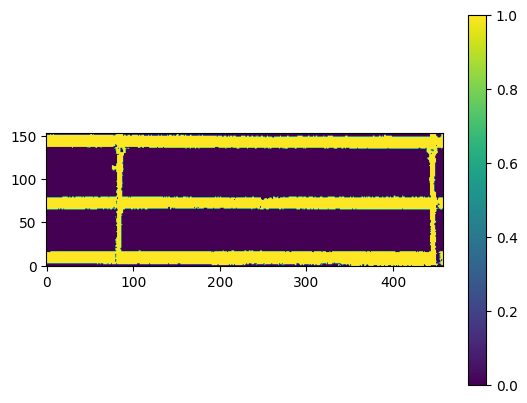

In [12]:
def do_raster(file):
    DECIMALS =1
    Multiplier = 100
    pcd = o3d.io.read_point_cloud(file)
    point_cloud = np.asarray(pcd.points)
    point_cloud= point_cloud*Multiplier
    # point_cloud = point_cloud.round(DECIMALS)
    # point_cloud = point_cloud.round(DECIMALS)
    point_cloud = np.unique(point_cloud,axis=0)
    def get_bounds(np_array ):
        x_min = np.min(np_array[:,0])
        x_max = np.max(np_array[:,0])
        y_min = np.min(np_array[:,2])
        y_max = np.max(np_array[:,2])
        z_min = np.min(np_array[:,1])
        z_max = np.max(np_array[:,1])
        return x_min,x_max,y_min,y_max,z_min,z_max
    def offset(np_array, x, y, z):
        np_array[:,0]=np_array[:,0]-x
        np_array[:,2]=np_array[:,2]-y
        np_array[:,1]=np_array[:,1]-z
        return np_array
        

    def offset_to_zero(np_array):
        x_min,x_max,y_min,y_max,z_min,z_max = get_bounds(np_array)
        return offset(np_array,x_min,y_min,z_min)

    point_cloud = offset_to_zero(point_cloud)
    x_min,x_max,y_min,y_max,z_min,z_max = get_bounds(point_cloud)
    # print(f"x:[{x_min},{x_max}],y:[{y_min},{y_max}],z:[{z_min},{z_max}]")

    x_dim = x_max-x_min
    y_dim = y_max-y_min
    z_dim = z_max-z_min
    print(f"x_dim:[{x_dim}],y_dim:[{y_dim}],z_dim:[{z_dim}]")

    def create_bitmap(np_array,x_dim,y_dim,z_dim):
        array = np.zeros(shape=(max([int(z_dim)+1]),max([int(x_dim)+1])))
        for row in np_array:
            # print(row)
            array[math.floor(row[1]),math.floor(row[0])] = 1
        return array

    im = create_bitmap(point_cloud,x_dim,y_dim,z_dim)
    # print(im.shape)
    # im = np.rot90(im[:,:])


    
    return im
im = do_raster("../Scaled/scen12.pcd")
plt.imshow(im,  origin='lower')
plt.colorbar()
plt.show()

In [3]:
import numpy as np

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line as draw_line
from skimage import data
from numpy.linalg import norm

import matplotlib.pyplot as plt
from matplotlib import cm


# Constructing test image
# image = np.zeros((200, 200))
# idx = np.arange(25, 175)

# image[idx, idx] = 255
# image[draw_line(45, 25, 25, 175)] = 255
# image[draw_line(25, 135, 175, 155)] = 255
def perform_hough(im, im_org, from_angle,to_angle,steps, number_of_lines, min_distance):
    image =im
    # Classic straight-line Hough transform
    # Set a precision of 0.5 degree.
    # tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    tested_angles = np.linspace(np.deg2rad(from_angle), np.deg2rad(to_angle), steps, endpoint=True)
    h, theta, d = hough_line(image, theta=tested_angles)

    # Generating figure 1
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    ax = axes.ravel()

    ax[0].imshow(image, cmap=cm.gray,origin='lower')# 
    ax[0].set_title('Input image')
    # ax[0].set_axis_off()

    angle_step = 0.5 * np.diff(theta).mean()
    d_step = 0.5 * np.diff(d).mean()
    bounds = [d[-1] + d_step, d[0] - d_step, np.rad2deg(theta[0] - angle_step),
            np.rad2deg(theta[-1] + angle_step)]
    ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')

    ax[2].imshow(im_org, cmap=cm.gray, origin='lower')
    # ax[2].set_ylim((0, image.shape[0]))
    # ax[2].set_xlim((0, image.shape[1]))
    # ax[2].set_axis_off()
    ax[2].set_title('Detected lines')
    res = []
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d, num_peaks=number_of_lines,min_distance = min_distance)):
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))
        print((x0, y0))
        ax[2].scatter(x=x0, y=y0,c='r')
        slope = angle
        res.append([slope, x0,y0])
        
    

    plt.tight_layout()
    plt.show()
    return res

def search_along_line(slope, x_0,y_0,im):
    buffer = 10
    # im = np.pad(im, pad_width=buffer, mode='constant', constant_values=0)
    # res = np.pad(res, pad_width=buffer+1, mode='constant', constant_values=0)
    idx =max(x_0,0)
    idy = max(y_0,0)
    new = np.array([idy,idx])
    res = np.zeros(shape=im.shape)
    # slope = slope+90
    slope= slope-np.pi/2
    # print(f"slope: {slope}, ({np.rad2deg(slope)})")
    vector = -(np.array([np.sin(slope),np.cos(slope)]))
    # print(f"following vector - {vector}")
    im=im.astype(int)
    
    searcher=np.array(np.round(vector)*5).astype(int) + np.array([10,10])
    # im = np.pad(im, [(int(np.ceil(searcher[1])),),(int(np.ceil(searcher[0])),)], 'constant', constant_values=(0, 0))
    print(f"searching in vector - {searcher}")
    while 0<= idx <= res.shape[1] and 0<= idy <= res.shape[0]:

        x_low = min(max(int(idx)-searcher[1],0), im.shape[1])
        x_high =min(max(int(idx)+searcher[1],0), im.shape[1])
        y_low = min(max(int(idy)-searcher[0],0), im.shape[0])
        y_high = min(max(int(idy)+searcher[0],0), im.shape[0])
        # print(f"[{idy},{idx}] = {np.sum(im[y_low: y_high,x_low: x_high])}")
        # print(f" x= [{y_low}: {y_high}] y= [{x_low}: {x_high}]={np.sum(im[y_low: y_high,x_low: x_high])}")

        

        # print(im[y_low: y_high,x_low: x_high])
        # if np.any(im[int(idy)-1-buffer:int(idy)-1+buffer, int(idx)-1-buffer:int(idx)-1+buffer] == 1):
        #     res[int(idy)-1, int(idx)-1]=1
        
        # if np.any(im[int(idy)-searcher[0]:int(idy)+searcher[0], int(idx)-searcher[1]:int(idx)+searcher[1]] == 1):
        #     # res[int(idy)-1, int(idx)-1]=1
        res[int(idy)-1, int(idx)-1]= np.sum(im[y_low: y_high,x_low: x_high])
        # print(f"y [{int(idy)-searcher[1]}, {int(idy)+searcher[1]}] --- x [{int(idx)-searcher[0]}, {int(idx)+searcher[0]}] sume({np.sum(im[int(idy)-searcher[0]: int(idy)+searcher[0],int(idx)-searcher[0]: int(idx)+searcher[0]])})")
        # ind = np.array([idx,idy])
        new = new+vector
        # print(f"xy:{ind}+{vector} -> {new} ~ {np.round(new,0)}")
        idy, idx =np.round(new,0)

        
        
    return res


In [4]:
dictionary_res = {}
from glob import glob
from natsort import natsorted
for file in natsorted(glob("../Scaled/*13.pcd")):
    file_dict = {
                "poles":{},
                "boards":{}
            }
    print(f"-------!!!!!!!!!{file}!!!!!!!!!-------")
    im = do_raster(file)
    # im = np.flipud(im)
    im = binary_closing(im, iterations=5, structure=np.ones((2,2)))
    print("Looking for Poles")
    poles = perform_hough(im, -20,20,int(40/1),3,20)
    res = np.zeros(shape=im.shape)
 

    for idx_hough,pole in enumerate(poles):
        file_dict['poles'][f"{idx_hough}"] ={}
        temp = search_along_line(pole[0],pole[1],pole[2],im.astype(np.uint8))
        indexes = np.sort(np.where(temp>0))
        sets =[]
        try:
            start = [indexes[0][0], indexes[1][0]]

            print(f"len: {len(indexes[0])}")
            for idx in range(0,len(indexes[0])-1):
                if np.sqrt((indexes[0][idx+1]-indexes[0][idx] )**2 + (indexes[1][idx+1]-indexes[1][idx])**2) >5:
                    end= [indexes[0][idx], indexes[1][idx]]
                    sets.append([start, end])
                    start = [indexes[0][idx+1], indexes[1][idx+1]]
            end= [indexes[0][idx], indexes[1][idx]]
            sets.append([start, end])
            print(sets)
            for set_id,set in enumerate(sets):
                pole_dict = {"start":{"x":int(set[0][1]),"y":int(set[0][0])}, "end": {"x":int(set[1][1]),"y":int(set[1][0])}, "length":float(np.linalg.norm((np.array([set[1]])-np.array([set[0]]))))}
                file_dict['poles'][f"{idx_hough}"][f"{set_id}"] = pole_dict
                print(f"found a pole from {set[0]} -> {set[1]}, with len:{np.linalg.norm((np.array([set[1]])-np.array([set[0]])))}")

            # mean = np.mean(temp)
            x_min = np.min(indexes[1])
            x_max = np.max(indexes[1])
            y_min = np.min(indexes[0])
            y_max = np.max(indexes[0])
        except ValueError:
            print("No railing found")
            continue
        except IndexError as IE:
            print("No railing found")
            continue
        print(f"(x_min,y_min) : ({x_min},{y_min}) -> (x_max,y_max) : ({x_max},{y_max})")
        res = np.logical_or(temp>0, res)
        # break
    print("Looking for Boards")
    boards = perform_hough(im, 60,120,int(60/1), 3,15)
    
    for idx_hough, board in enumerate(boards):
        file_dict['boards'][f"{idx_hough}"] ={}
        temp = search_along_line(board[0]+np.pi,board[1],board[2],im.astype(np.uint8))
        indexes = np.sort(np.where(temp>0))
        sets =[]
        try: 
            start = [indexes[0][0], indexes[1][0]]
            print(f"len: {len(indexes[0])}")
            for idx in range(0,len(indexes[0])-1):
                if np.sqrt((indexes[0][idx+1]-indexes[0][idx] )**2 + (indexes[1][idx+1]-indexes[1][idx])**2) >5:
                    end= [indexes[0][idx], indexes[1][idx]]
                    sets.append([start, end])
                    start = [indexes[0][idx+1], indexes[1][idx+1]]
            end= [indexes[0][idx], indexes[1][idx]]
            sets.append([start, end])
            print(sets)
            for set_id,set in enumerate(sets):
                board_dict = {"start":{"x":int(set[0][1]),"y":int(set[0][0])}, "end": {"x":int(set[1][1]),"y":int(set[1][0])}, "length":float(np.linalg.norm((np.array([set[1]])-np.array([set[0]]))))}
                file_dict['boards'][f"{idx_hough}"][f"{set_id}"] = board_dict
                print(f"found a board from {set[0]} -> {set[1]}, with len:{np.linalg.norm((np.array([set[1]])-np.array([set[0]])))}")
            # indexes = np.where(temp>np.mean(temp[np.where(temp>0)]))
        
            x_min = np.min(indexes[1])
            x_max = np.max(indexes[1])
            y_min = np.min(indexes[0])
            y_max = np.max(indexes[0])
        except ValueError:
            print("No railing found")
            continue
        except IndexError as IE:
            print("No railing found")
            continue
        print(f"(x_min,y_min) : ({x_min},{y_min}) -> (x_max,y_max) : ({x_max},{y_max})")
        res = np.logical_or(temp>0, res)
    plt.imshow(res,  origin='lower')
    plt.colorbar()
    plt.show()
    dictionary_res[file] = file_dict
    # break

import json
with open("result.json", 'w+') as f:
    f.write(json.dumps(dictionary_res, indent=4))




-------!!!!!!!!!../Scaled/scen13.pcd!!!!!!!!!-------
x_dim:[433.01285803318024],y_dim:[23.991422285325825],z_dim:[131.8901475518942]
Looking for Poles


TypeError: perform_hough() missing 1 required positional argument: 'min_distance'

In [ ]:
#https://book.simply-logical.space/src/text/1_part_i/3.9.html

In [ ]:
with open("result.json") as f:
    dict = json.load(f)
string= ""
string += "% pole(FILE, START_X, START_Y, END_X, END_Y).\n"
string += "% board({file}, {board['start']['x']},{board['start']['y']}, {board['end']['x']}, {board['end']['y']}).\n"
for id,[file, obj] in enumerate(dict.items()):
    # print(obj)
    for hough in obj['poles'].values():
        for pole in hough.values():
            # print(pole['start']['x'])
            string += f"pole('{file}', {id}, {pole['start']['x']}, {pole['start']['y']}, {pole['end']['x']}, {pole['end']['y']}).\n"
    
for id, [file, obj] in enumerate(dict.items()):  
    for hough in obj['boards'].values():
        for board in hough.values():
            string += f"board('{file}', {id}, {board['start']['x']}, {board['start']['y']}, {board['end']['x']}, {board['end']['y']}).\n"

with open("../Prolog/knowledge.pl", 'w+') as f:
    f.write(string)

NameError: name 'json' is not defined

In [ ]:
print(im[int(126)-1-5:int(126)-1+5, int(7)-1-5:int(7)-1+5])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [ ]:
int(126)-1-5
int(126)-1+5

130

In [6]:
def perform_hough(im, im_org, from_angle,to_angle,steps, number_of_lines, min_distance):
    image =im
    # Classic straight-line Hough transform
    # Set a precision of 0.5 degree.
    # tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    tested_angles = np.linspace(np.deg2rad(from_angle), np.deg2rad(to_angle), steps, endpoint=True)
    h, theta, d = hough_line(image, theta=tested_angles)

    # Generating figure 1
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    ax = axes.ravel()

    ax[0].imshow(image, cmap=cm.gray,origin='lower')# 
    ax[0].set_title('Input image')
    ax[0].set_axis_off()
    degree_sym =u"\u00b0"
    arrow_syb = u"\u2192"
    
    angle_step = 0.5 * np.diff(theta).mean()
    d_step = 0.5 * np.diff(d).mean()
    bounds = [d[0] - d_step,d[-1] + d_step, 
            np.rad2deg(theta[0] - angle_step),
            np.rad2deg(theta[-1] + angle_step)]
    ax[1].imshow(np.log(1 + h).T, extent=bounds, cmap=cm.gray, aspect=10)
    # ax[1].tick_params(axis='x', which='major', pad=15)
    ax[1].set_title(f'Hough transform [{from_angle}{degree_sym}, {to_angle}{degree_sym}]')
    ax[1].set_ylabel('Angles (degrees)')
    ax[1].set_xlabel('Distance (pixels)')
    ax[1].axis('image')
    ax[1].set_xbound(lower=0)
    # ax[1].invert_xaxis()

    ax[2].imshow(image, cmap=cm.gray, origin='lower')
    ax[2].set_ylim((0, image.shape[0]))
    ax[2].set_xlim((0, image.shape[1]))
    ax[2].set_axis_off()
    ax[2].set_title('Detected lines')
   
    res = []
    
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d, num_peaks=number_of_lines,min_distance = min_distance)):
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2),color="red",  linestyle='--', linewidth=2)
        print((x0, y0))
        ax[2].scatter(x=x0, y=y0,c='r')
        slope = angle
        res.append([slope, x0,y0])

    # plt.tight_layout()
    # plt.show()
    return res

def search_along_line(slope, x_0,y_0,im):
    buffer = 10
    slope= slope-np.pi/2
    # print(f"slope: {slope}, ({np.rad2deg(slope)})")
    vector = -(np.array([np.sin(slope),np.cos(slope)]))


    # im = np.pad(im, pad_width=buffer, mode='constant', constant_values=0)
    # res = np.pad(res, pad_width=buffer+1, mode='constant', constant_values=0)
    idx =max(x_0,0)
    idy = max(y_0,0)
    new = np.array([idy,idx])
    res = np.zeros(shape=im.shape)
    # slope = slope+90
  
    # print(f"following vector - {vector}")
    im=im.astype(int)
    
    searcher=np.array(np.round(vector)*5).astype(int) + np.array([10,10])
    # im = np.pad(im, [(int(np.ceil(searcher[1])),),(int(np.ceil(searcher[0])),)], 'constant', constant_values=(0, 0))
    # print(f"searching in vector - {searcher}")
    while 0<= idx <= res.shape[1] and 0<= idy <= res.shape[0]:

        x_low = min(max(int(idx)-searcher[1],0), im.shape[1])
        x_high =min(max(int(idx)+searcher[1],0), im.shape[1])
        y_low = min(max(int(idy)-searcher[0],0), im.shape[0])
        y_high = min(max(int(idy)+searcher[0],0), im.shape[0])
        res[int(idy)-1, int(idx)-1]= np.sum(im[y_low: y_high,x_low: x_high])
        new = new+vector
        idy, idx =np.round(new,0)

        
        
    return res


-------!!!!!!!!!../Scaled/scen1.pcd!!!!!!!!!-------
x_dim:[419.2257881164551],y_dim:[47.55444526672363],z_dim:[140.30108451843262]
Looking for poles
(231.99096652347586, 2.0473034712746703)
(405.98419141608275, 3.582781074730673)
(75.99704075769037, -0.6706683785210127)
Looking for Boards
(1.0392533350031723, 130.99587761645662)
(0.5315265148489506, 66.99789160536332)
(0.07139908408418741, 8.999716782809998)
len: 140
[[[1, 230], [139, 231]]]
found a pole from [1, 230] -> [139, 231], with len:138.00362314084367
(x_min,y_min) : (230,1) -> (x_max,y_max) : (231,140)
len: 138
[[[2, 404], [139, 405]]]
found a pole from [2, 404] -> [139, 405], with len:137.00364958642524
(x_min,y_min) : (404,2) -> (x_max,y_max) : (405,140)
len: 142
[[[0, 74], [140, 76]]]
found a pole from [0, 74] -> [140, 76], with len:140.0142849854971
(x_min,y_min) : (74,0) -> (x_max,y_max) : (76,140)
Looking for Boards
len: 420
[[[127, 0], [130, 418]]]
found a board from [127, 0] -> [130, 418], with len:418.01076541160995


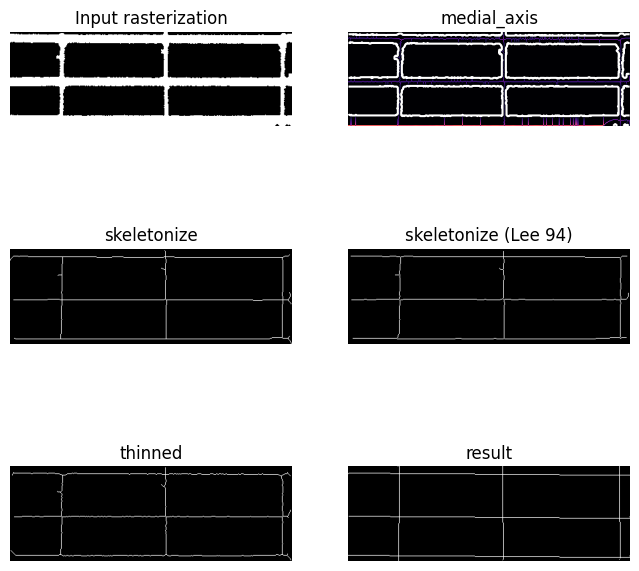

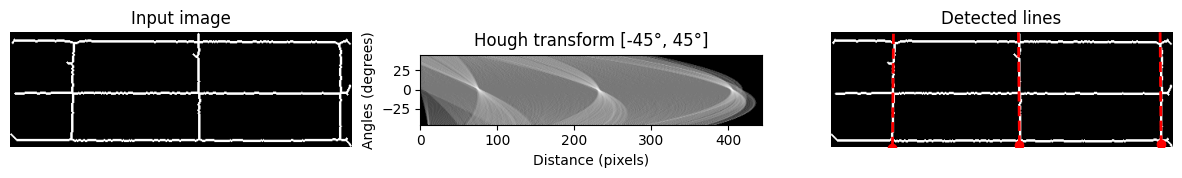

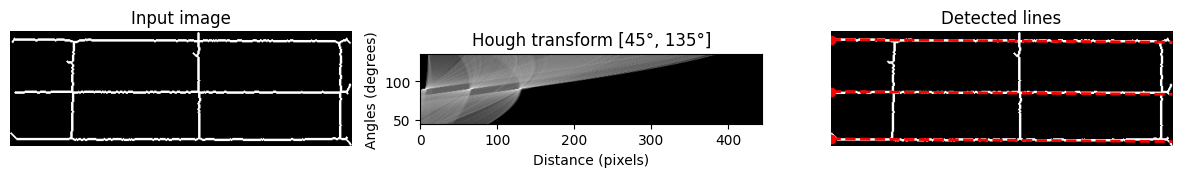

-------!!!!!!!!!../Scaled/scen2.pcd!!!!!!!!!-------
x_dim:[416.4261817932129],y_dim:[30.602359771728516],z_dim:[137.78085708618164]
Looking for poles
(235.99081077388064, -2.0826018069863026)
(408.98407460388637, -3.6092548265143973)
(81.99680713329751, -0.7236158820884611)
Looking for Boards
(0.523593283284041, 65.99792307393999)
(1.0313201034382624, 129.9959090850333)
len: 139
[[[0, 234], [137, 236]]]
found a pole from [0, 234] -> [137, 236], with len:137.01459776242822
(x_min,y_min) : (234,0) -> (x_max,y_max) : (236,137)
len: 139
[[[0, 407], [137, 409]]]
found a pole from [0, 407] -> [137, 409], with len:137.01459776242822
(x_min,y_min) : (407,0) -> (x_max,y_max) : (409,137)
len: 139
[[[0, 80], [137, 82]]]
found a pole from [0, 80] -> [137, 82], with len:137.01459776242822
(x_min,y_min) : (80,0) -> (x_max,y_max) : (82,137)
Looking for Boards
len: 417
[[[62, 1], [65, 416]]]
found a board from [62, 1] -> [65, 416], with len:415.01084323183653
(x_min,y_min) : (1,62) -> (x_max,y_max) : 

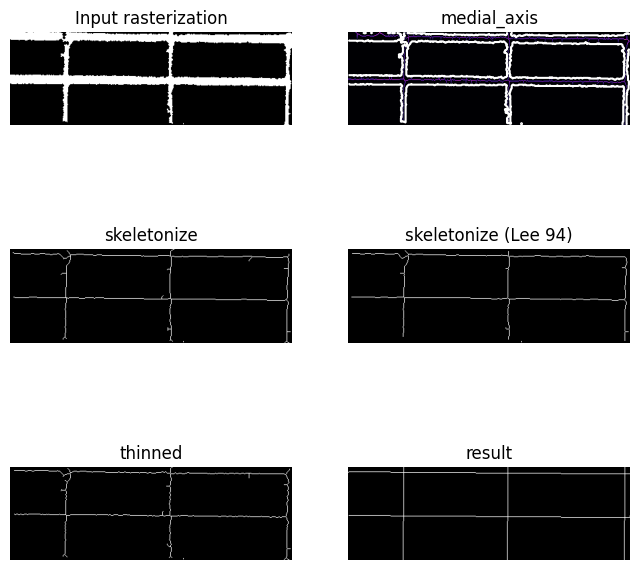

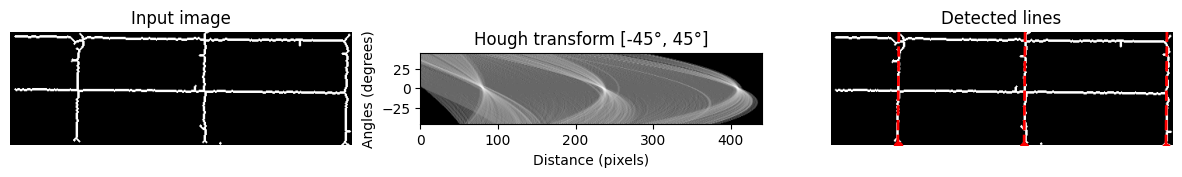

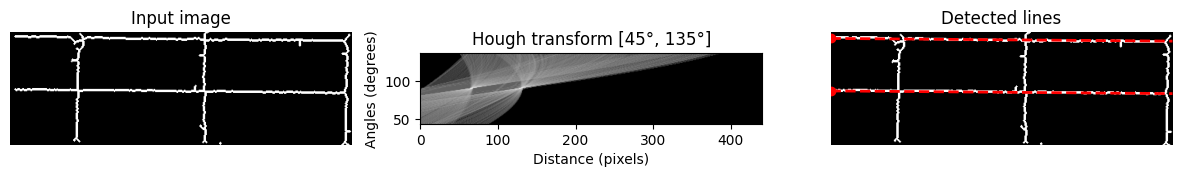

-------!!!!!!!!!../Scaled/scen3.pcd!!!!!!!!!-------
x_dim:[405.1492691040039],y_dim:[47.368860989809036],z_dim:[137.98008263111115]
Looking for poles
(388.98485335186257, -3.432763147956236)
(61.99758588127372, 0.5471242035302998)
(217.92360878965422, 5.770678651054972)
Looking for Boards
(-0.047599389389458874, 5.999811188539999)
(-0.9916539456137266, 124.99606642791663)
len: 139
[[[0, 387], [137, 389]]]
found a pole from [0, 387] -> [137, 389], with len:137.01459776242822
(x_min,y_min) : (387,0) -> (x_max,y_max) : (389,137)
len: 137
[[[1, 60], [136, 61]]]
found a pole from [1, 60] -> [136, 61], with len:135.00370365289984
(x_min,y_min) : (60,1) -> (x_max,y_max) : (61,137)
len: 133
[[[4, 213], [136, 217]]]
found a pole from [4, 213] -> [136, 217], with len:132.06059215375342
(x_min,y_min) : (213,4) -> (x_max,y_max) : (217,137)
Looking for Boards
len: 407
[[[4, 0], [8, 405]]]
found a board from [4, 0] -> [8, 405], with len:405.0197526047341
(x_min,y_min) : (0,4) -> (x_max,y_max) : (405

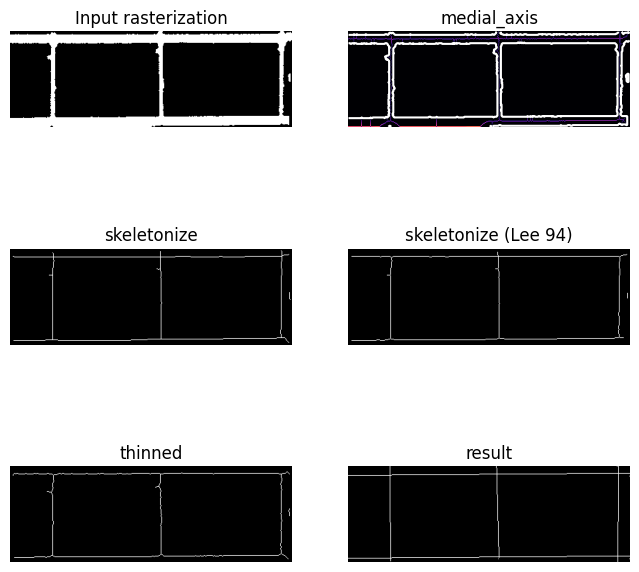

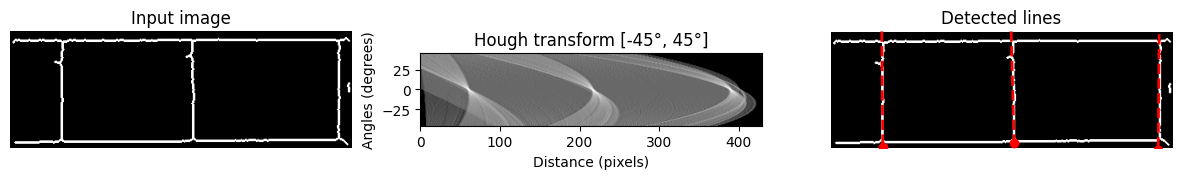

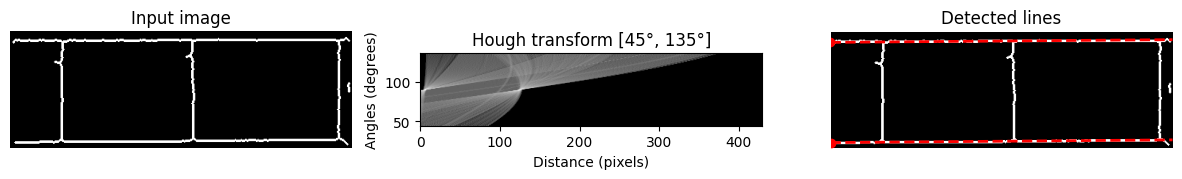

-------!!!!!!!!!../Scaled/scen4.pcd!!!!!!!!!-------
x_dim:[472.36459217965603],y_dim:[81.59030601382256],z_dim:[141.38384014368057]
Looking for poles
(237.990732899083, 2.1002509748421185)
(411.98395779168993, -3.6357285782981212)
(79.99688500809513, -0.7059667142326449)
Looking for Boards
(0.5711926726734993, 71.99773426247998)
(0.1269317050385554, 15.99949650277333)
len: 141
[[[1, 236], [140, 237]]]
found a pole from [1, 236] -> [140, 237], with len:139.00359707575916
(x_min,y_min) : (236,1) -> (x_max,y_max) : (237,141)
len: 143
[[[0, 410], [141, 412]]]
found a pole from [0, 410] -> [141, 412], with len:141.01418368376991
(x_min,y_min) : (410,0) -> (x_max,y_max) : (412,141)
len: 143
[[[0, 78], [141, 80]]]
found a pole from [0, 78] -> [141, 80], with len:141.01418368376991
(x_min,y_min) : (78,0) -> (x_max,y_max) : (80,141)
Looking for Boards
len: 460
[[[67, 1], [71, 459]], [[71, 472], [71, 459]]]
found a board from [67, 1] -> [71, 459], with len:458.0174669158372
(x_min,y_min) : (1,67

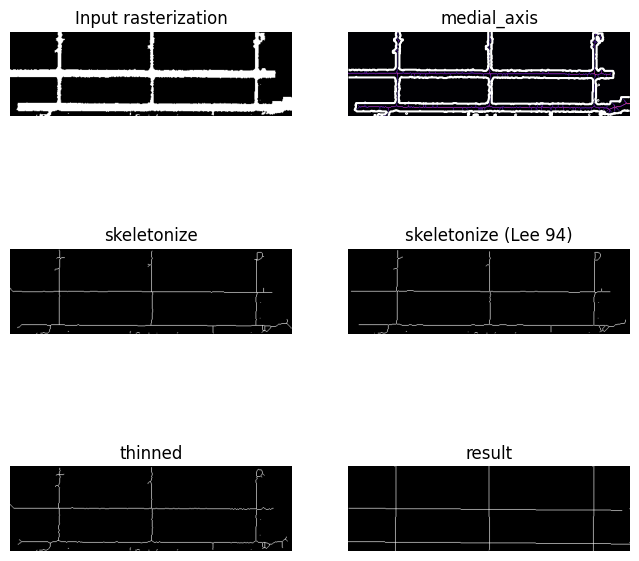

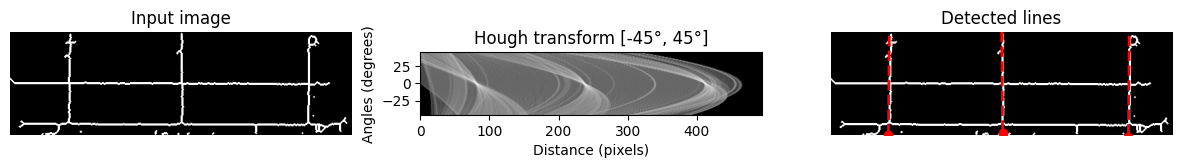

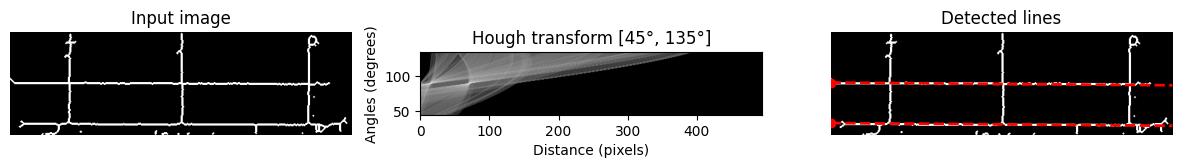

-------!!!!!!!!!../Scaled/scen5.pcd!!!!!!!!!-------
x_dim:[429.9128331243992],y_dim:[78.24893724173307],z_dim:[141.80173072963953]
Looking for poles
(234.91765167692085, 6.220685701825314)
(76.99700182029156, 0.6794929624489208)
(411.8556276208144, 10.906053230434168)
Looking for Boards
(-0.03966615782454906, 4.999842657116665)
(0.5632594411085895, 70.99776573105665)
(-0.3044864922699069, 0.9525166539358605)
len: 137
[[[5, 230], [140, 234]]]
found a pole from [5, 230] -> [140, 234], with len:135.05924625881784
(x_min,y_min) : (230,5) -> (x_max,y_max) : (234,141)
len: 141
[[[1, 75], [140, 76]]]
found a pole from [1, 75] -> [140, 76], with len:139.00359707575916
(x_min,y_min) : (75,1) -> (x_max,y_max) : (76,141)
len: 132
[[[9, 407], [140, 411]]]
found a pole from [9, 407] -> [140, 411], with len:131.06105447462264
(x_min,y_min) : (407,9) -> (x_max,y_max) : (411,141)
Looking for Boards
len: 431
[[[3, 0], [7, 429]]]
found a board from [3, 0] -> [7, 429], with len:429.01864761336424
(x_min,

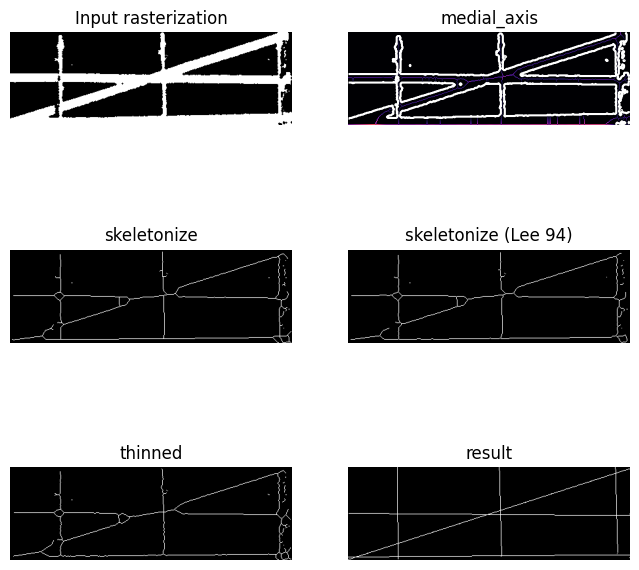

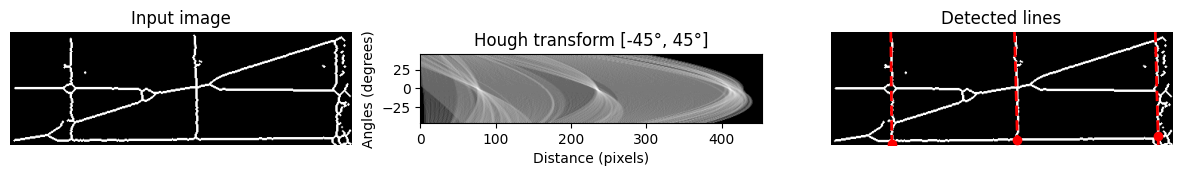

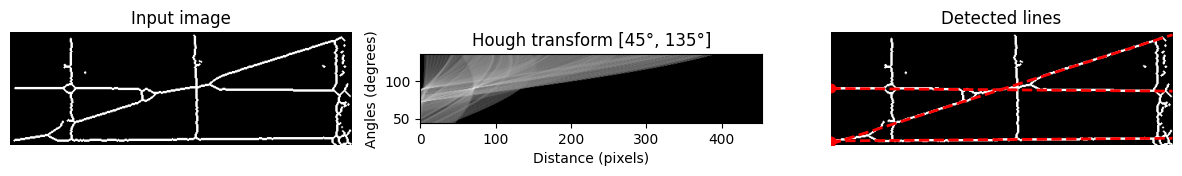

-------!!!!!!!!!../Scaled/scen6.pcd!!!!!!!!!-------
x_dim:[420.1603412628174],y_dim:[33.07768106460571],z_dim:[141.32553339004517]
Looking for poles
(404.98423035348156, 3.573956490802765)
(227.9201046056934, 6.035388680919879)
(67.99735225688086, 0.6000717070977482)
Looking for Boards
(-1.015453640308456, 127.99597202218663)
(-0.19703515662873275, 0.980396423418757)
(-0.047599389389458874, 5.999811188539999)
len: 139
[[[2, 403], [140, 404]]]
found a pole from [2, 403] -> [140, 404], with len:138.00362314084367
(x_min,y_min) : (403,2) -> (x_max,y_max) : (404,141)
len: 137
[[[5, 223], [140, 227]]]
found a pole from [5, 223] -> [140, 227], with len:135.05924625881784
(x_min,y_min) : (223,5) -> (x_max,y_max) : (227,141)
len: 141
[[[1, 66], [140, 67]]]
found a pole from [1, 66] -> [140, 67], with len:139.00359707575916
(x_min,y_min) : (66,1) -> (x_max,y_max) : (67,141)
Looking for Boards
len: 422
[[[126, 0], [130, 420]]]
found a board from [126, 0] -> [130, 420], with len:420.0190471871484

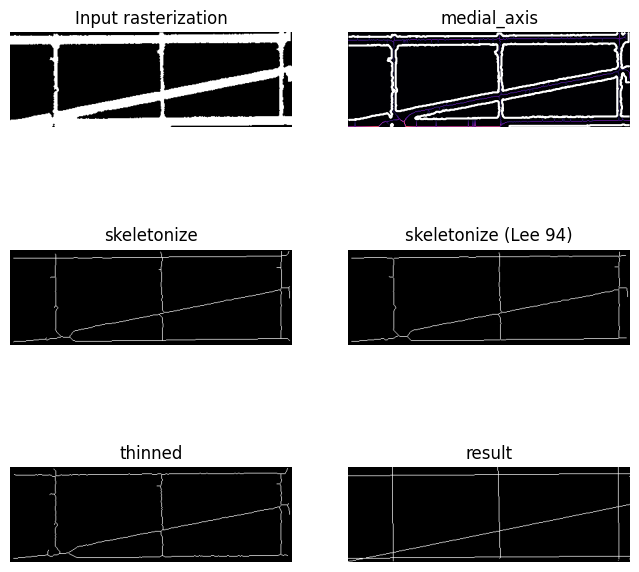

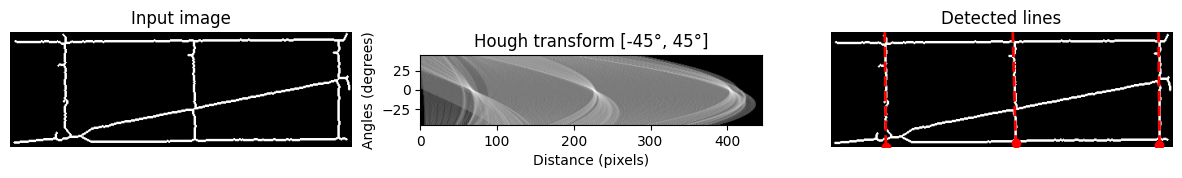

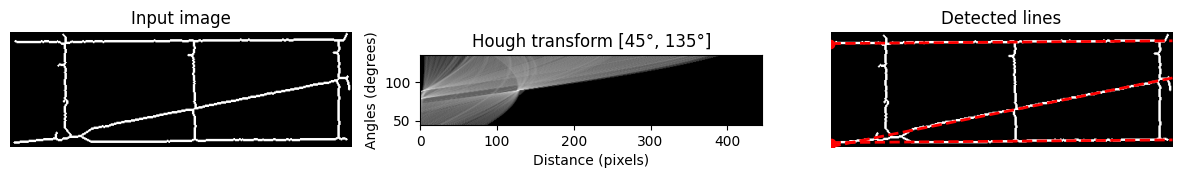

-------!!!!!!!!!../Scaled/scen7.pcd!!!!!!!!!-------
x_dim:[372.02875316143036],y_dim:[35.30331775546074],z_dim:[140.433856472373]
Looking for poles
(184.99279658121998, 1.6325480266629915)
(358.9860214738269, -3.168025630118994)
(28.998870815434483, -0.2559129339093338)
Looking for Boards
(-0.8171228511857107, 102.99675873660331)
(1.0392533350031723, 130.99587761645662)
(0.07139908408418741, 8.999716782809998)
len: 140
[[[0, 183], [139, 184]]]
found a pole from [0, 183] -> [139, 184], with len:139.00359707575916
(x_min,y_min) : (183,0) -> (x_max,y_max) : (184,140)
len: 142
[[[0, 357], [140, 359]]]
found a pole from [0, 357] -> [140, 359], with len:140.0142849854971
(x_min,y_min) : (357,0) -> (x_max,y_max) : (359,140)
len: 142
[[[0, 27], [140, 29]]]
found a pole from [0, 27] -> [140, 29], with len:140.0142849854971
(x_min,y_min) : (27,0) -> (x_max,y_max) : (29,140)
Looking for Boards
len: 374
[[[101, 0], [105, 372]]]
found a board from [101, 0] -> [105, 372], with len:372.0215047547655


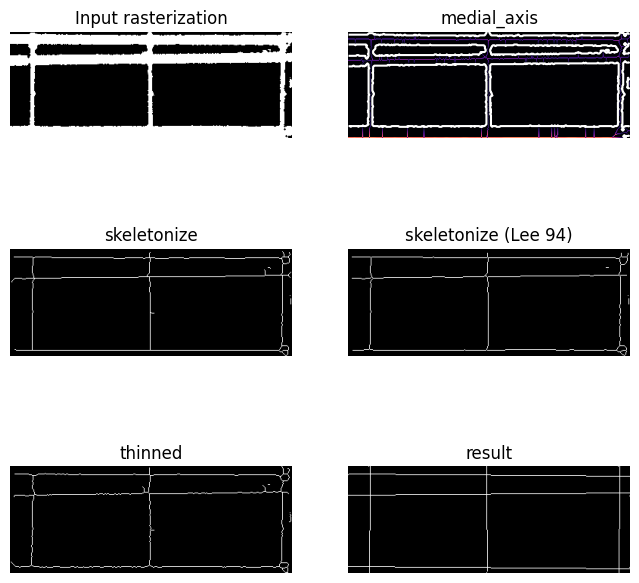

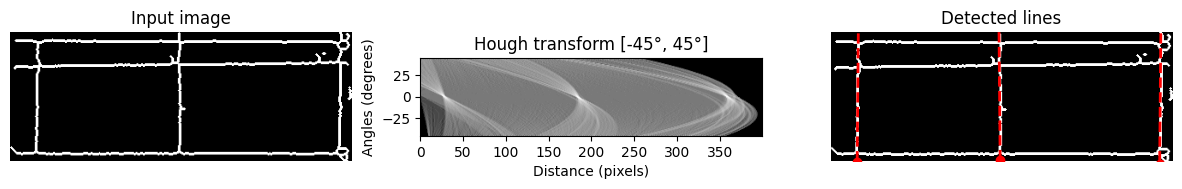

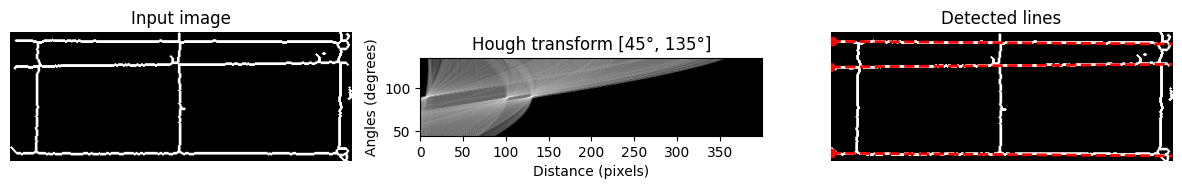

-------!!!!!!!!!../Scaled/scen8.pcd!!!!!!!!!-------
x_dim:[425.148618593812],y_dim:[59.85075533390045],z_dim:[137.57407125085592]
Looking for poles
(411.8556276208144, -10.906053230434168)
(237.990732899083, 2.1002509748421185)
(80.99684607069632, 0.714791298160553)
Looking for Boards
(0.0634658525192777, 7.999748251386665)
(-0.2617966416420238, 32.99896153696999)
(-0.9995871771786363, 125.99603495933997)
len: 139
[[[0, 410], [137, 414]]]
found a pole from [0, 410] -> [137, 414], with len:137.05838172107534
(x_min,y_min) : (410,0) -> (x_max,y_max) : (415,137)
len: 137
[[[1, 236], [136, 237]]]
found a pole from [1, 236] -> [136, 237], with len:135.00370365289984
(x_min,y_min) : (236,1) -> (x_max,y_max) : (237,137)
len: 137
[[[1, 79], [136, 80]]]
found a pole from [1, 79] -> [136, 80], with len:135.00370365289984
(x_min,y_min) : (79,1) -> (x_max,y_max) : (80,137)
Looking for Boards
len: 427
[[[4, 0], [7, 425]]]
found a board from [4, 0] -> [7, 425], with len:425.0105881034024
(x_min,y_mi

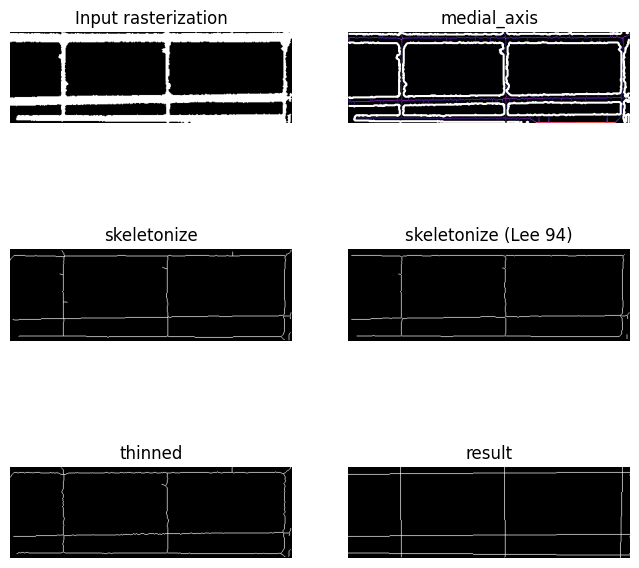

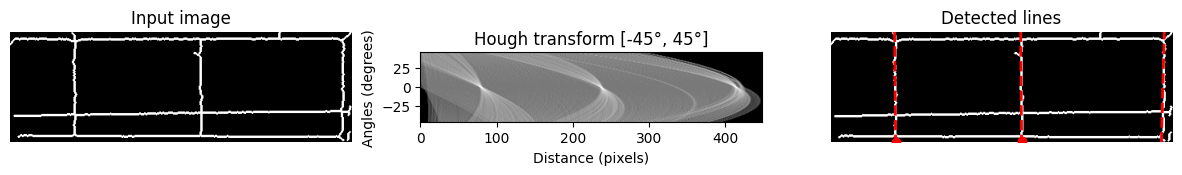

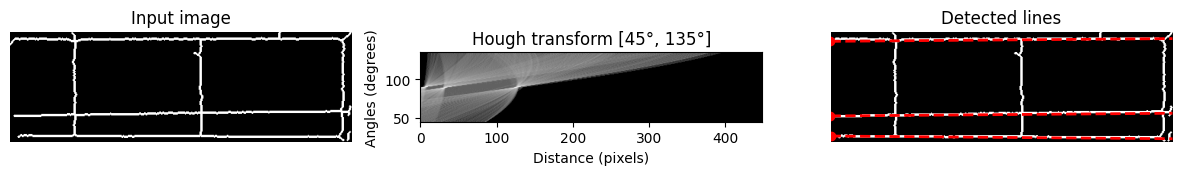

-------!!!!!!!!!../Scaled/scen9.pcd!!!!!!!!!-------
x_dim:[378.92309725284576],y_dim:[44.084786728490144],z_dim:[139.6234517917037]
Looking for poles
(371.98551528764233, -3.282745221181799)
(199.9922125202378, 1.7649167855816124)
(47.99813100485708, 0.423580028539587)
Looking for Boards
(-0.055532620954368686, 6.999779719963332)
(-0.9995871771786363, 125.99603495933997)
(-0.49979358858931816, 62.99801747966998)
len: 141
[[[0, 370], [139, 372]]]
found a pole from [0, 370] -> [139, 372], with len:139.01438774457844
(x_min,y_min) : (370,0) -> (x_max,y_max) : (372,139)
len: 139
[[[0, 198], [138, 199]]]
found a pole from [0, 198] -> [138, 199], with len:138.00362314084367
(x_min,y_min) : (198,0) -> (x_max,y_max) : (199,139)
len: 140
[[[0, 46], [138, 47]]]
found a pole from [0, 46] -> [138, 47], with len:138.00362314084367
(x_min,y_min) : (46,0) -> (x_max,y_max) : (47,139)
Looking for Boards
len: 380
[[[5, 0], [9, 378]]]
found a board from [5, 0] -> [9, 378], with len:378.02116342871597
(x_

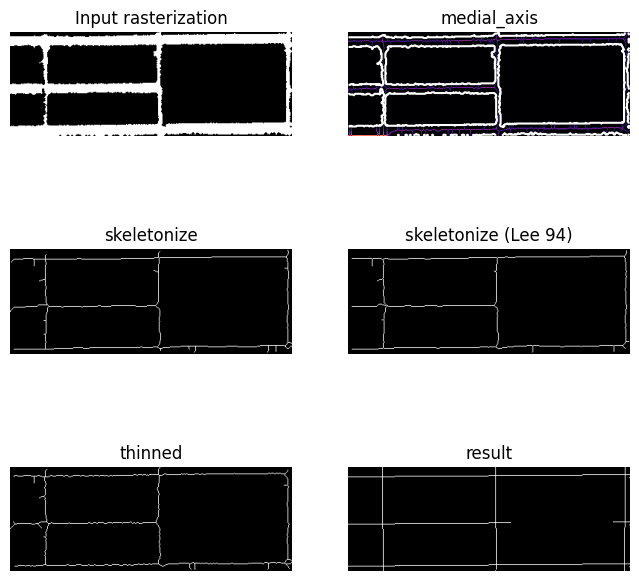

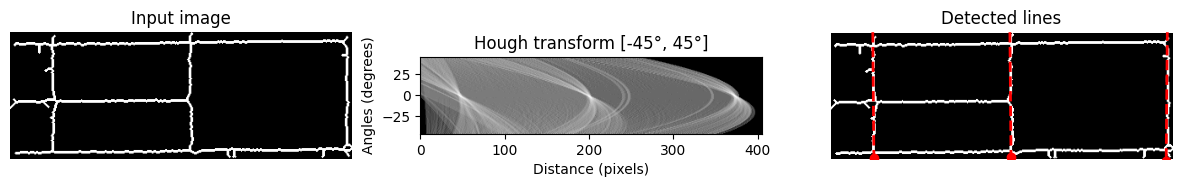

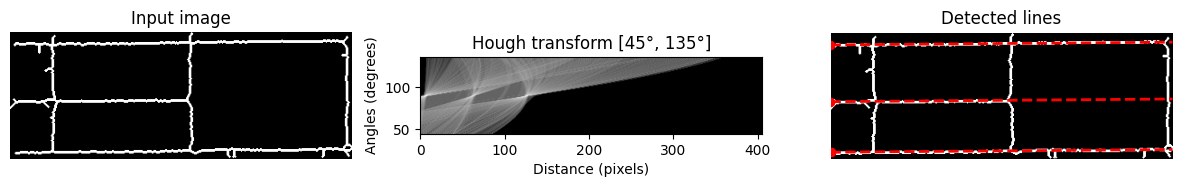

-------!!!!!!!!!../Scaled/scen10.pcd!!!!!!!!!-------
x_dim:[364.47604298591614],y_dim:[48.85394163429737],z_dim:[144.7182558476925]
Looking for poles
(359.9859825364281, -3.1768502140469024)
(19.999221252023784, -0.17649167855816122)
(181.99291339341642, 1.6060742748792671)
Looking for Boards
(-0.055532620954368686, 6.999779719963332)
(1.0709862612628112, 134.99575174214996)
(-0.5235932832840476, 65.99792307393999)
len: 146
[[[0, 358], [144, 360]]]
found a pole from [0, 358] -> [144, 360], with len:144.01388821915754
(x_min,y_min) : (358,0) -> (x_max,y_max) : (360,144)
len: 146
[[[0, 18], [144, 20]]]
found a pole from [0, 18] -> [144, 20], with len:144.01388821915754
(x_min,y_min) : (18,0) -> (x_max,y_max) : (20,144)
len: 144
[[[0, 180], [143, 181]]]
found a pole from [0, 180] -> [143, 181], with len:143.0034964607509
(x_min,y_min) : (180,0) -> (x_max,y_max) : (181,144)
Looking for Boards
len: 327
[[[5, 0], [8, 302]], [[8, 342], [9, 364]]]
found a board from [5, 0] -> [8, 302], with le

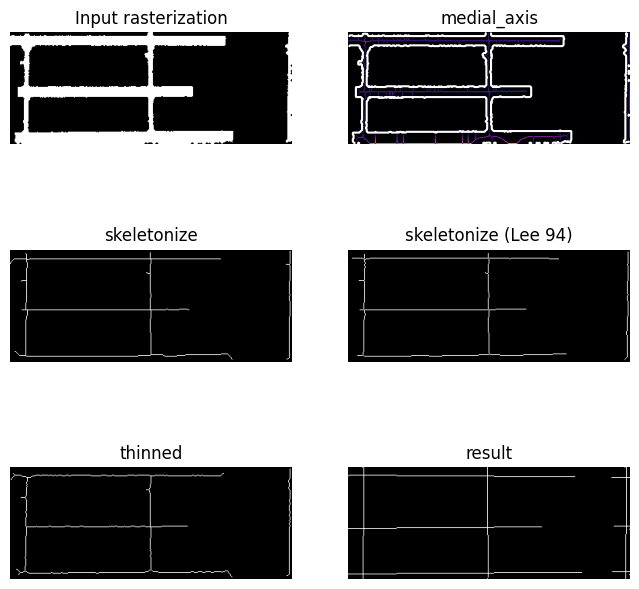

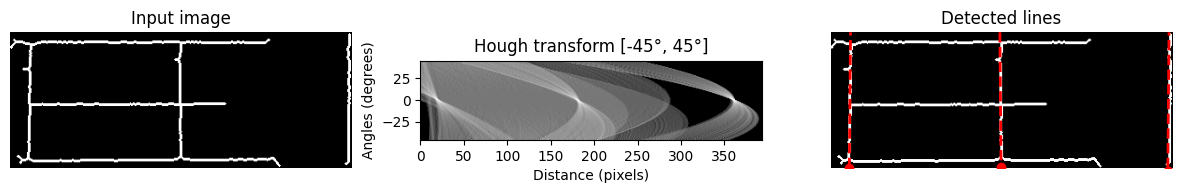

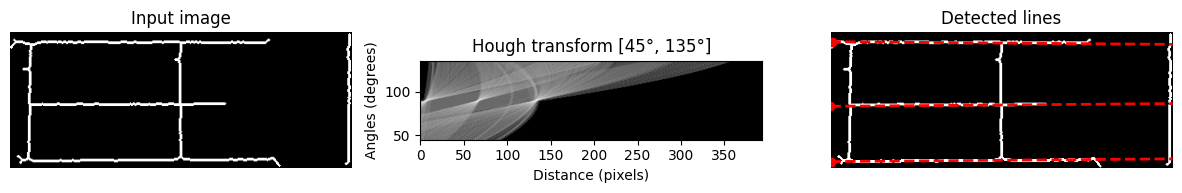

-------!!!!!!!!!../Scaled/scen11.pcd!!!!!!!!!-------
x_dim:[353.1831204891205],y_dim:[99.2270948830992],z_dim:[155.5312561802566]
Looking for poles
(6.999727438208324, -0.06177208749535643)
(166.9414801278544, 4.420657498743947)
(337.9868391592019, -2.982709367632925)
Looking for Boards
(-1.015453640308456, 127.99597202218663)
(-0.0634658525192785, 7.999748251386665)
(-0.5156600517191378, 64.99795454251665)
len: 157
[[[0, 5], [155, 7]]]
found a pole from [0, 5] -> [155, 7], with len:155.0129026887762
(x_min,y_min) : (5,0) -> (x_max,y_max) : (7,155)
len: 151
[[[3, 162], [152, 166]]]
found a pole from [3, 162] -> [152, 166], with len:149.05368160498418
(x_min,y_min) : (162,3) -> (x_max,y_max) : (166,153)
len: 155
[[[0, 336], [153, 338]]]
found a pole from [0, 336] -> [153, 338], with len:153.0130713370593
(x_min,y_min) : (336,0) -> (x_max,y_max) : (338,155)
Looking for Boards
len: 326
[[[126, 0], [127, 31]], [[127, 61], [130, 353]]]
found a board from [127, 61] -> [130, 353], with len:29

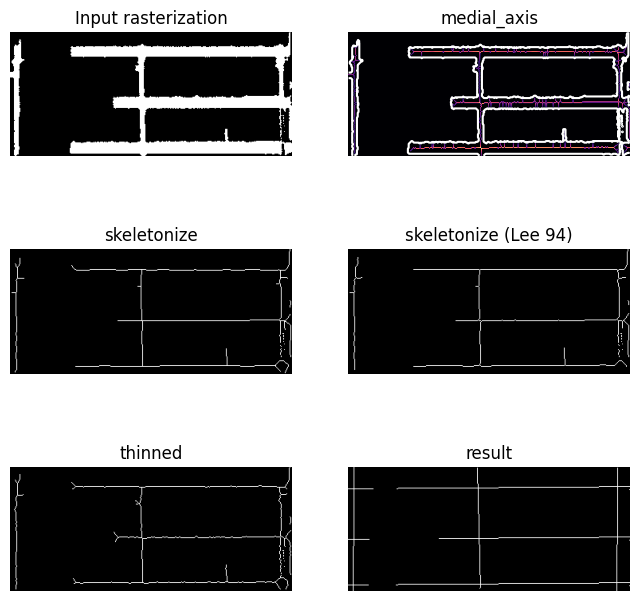

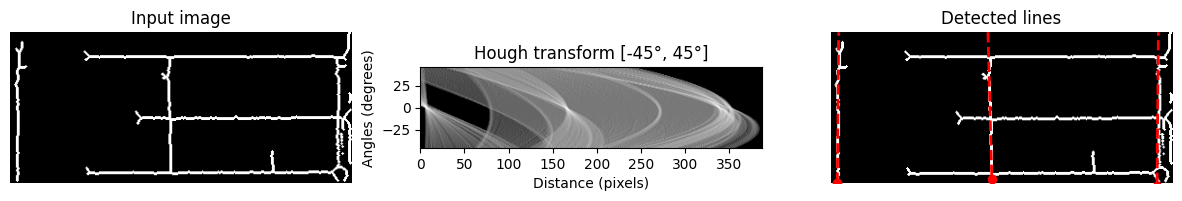

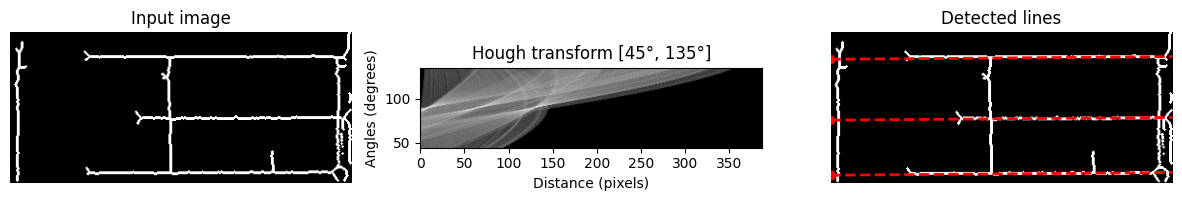

-------!!!!!!!!!../Scaled/scen12.pcd!!!!!!!!!-------
x_dim:[457.74582624435425],y_dim:[34.4486762303859],z_dim:[152.7513027191162]
Looking for poles
(445.98263392013035, 3.9357644318469953)
(82.9967681958987, -0.7324404660163691)
Looking for Boards
(1.1423853453469985, 143.99546852495996)
(0.08726554721400683, 10.999653845656663)
(0.5870591358033187, 73.99767132532665)
len: 150
[[[2, 444], [151, 445]]]
found a pole from [2, 444] -> [151, 445], with len:149.00335566691106
(x_min,y_min) : (444,2) -> (x_max,y_max) : (445,152)
len: 154
[[[0, 81], [152, 83]]]
found a pole from [0, 81] -> [152, 83], with len:152.0131573252789
(x_min,y_min) : (81,0) -> (x_max,y_max) : (83,152)
Looking for Boards
len: 458
[[[139, 0], [143, 456]]]
found a board from [139, 0] -> [143, 456], with len:456.01754352217637
(x_min,y_min) : (0,139) -> (x_max,y_max) : (457,143)
len: 459
[[[6, 0], [10, 457]]]
found a board from [6, 0] -> [10, 457], with len:457.0175051351972
(x_min,y_min) : (0,6) -> (x_max,y_max) : (457,

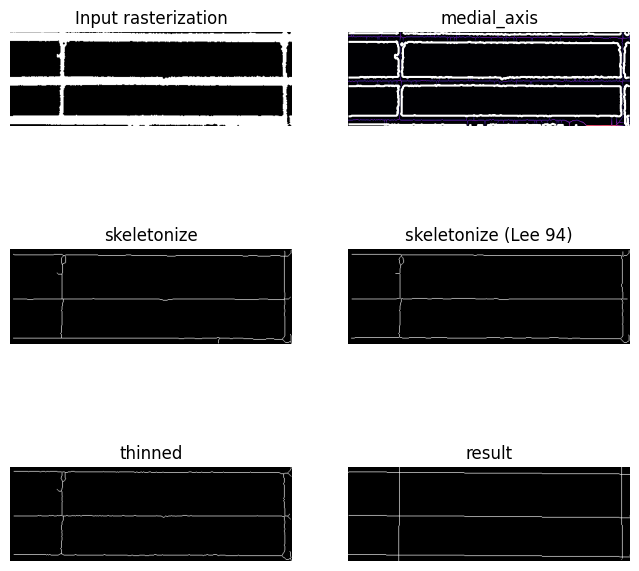

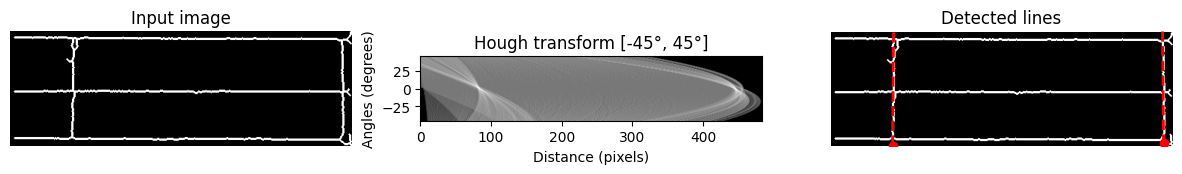

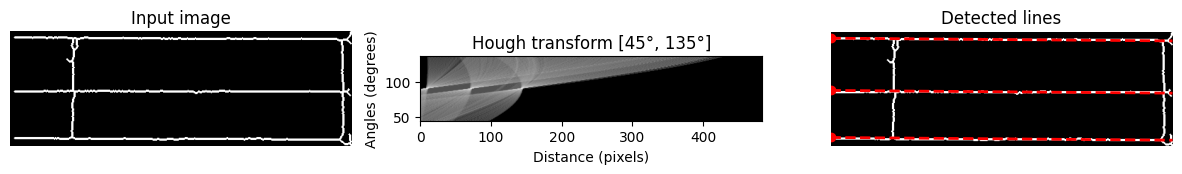

-------!!!!!!!!!../Scaled/scen13.pcd!!!!!!!!!-------
x_dim:[433.01285803318024],y_dim:[23.991422285325825],z_dim:[131.8901475518942]
Looking for poles
(421.9835684177018, -3.723974417577202)
(89.96846234435266, -2.382390268784163)
Looking for Boards
(0.9837207140488042, 123.9960978964933)
(0.4918603570244021, 61.99804894824665)
len: 133
[[[0, 420], [131, 422]]]
found a pole from [0, 420] -> [131, 422], with len:131.01526628603247
(x_min,y_min) : (420,0) -> (x_max,y_max) : (422,131)
len: 133
[[[0, 88], [131, 92]]]
found a pole from [0, 88] -> [131, 92], with len:131.06105447462264
(x_min,y_min) : (88,0) -> (x_max,y_max) : (92,131)
Looking for Boards
len: 434
[[[120, 1], [123, 433]]]
found a board from [120, 1] -> [123, 433], with len:432.010416541083
(x_min,y_min) : (1,120) -> (x_max,y_max) : (433,123)
len: 435
[[[58, 0], [61, 433]]]
found a board from [58, 0] -> [61, 433], with len:433.01039248498415
(x_min,y_min) : (0,58) -> (x_max,y_max) : (433,61)


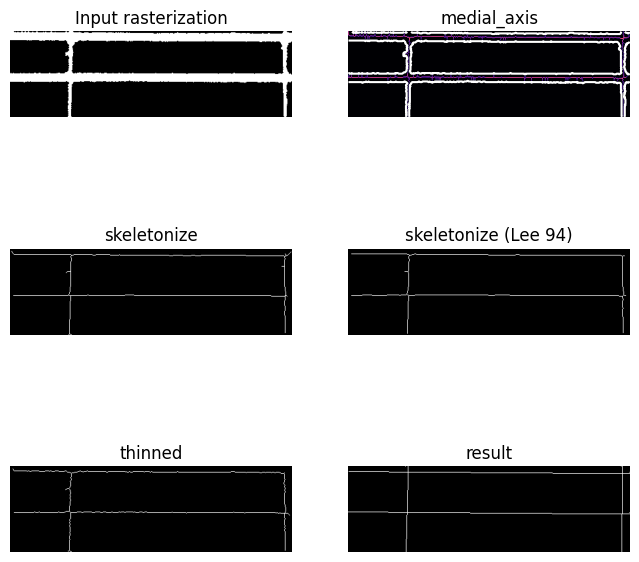

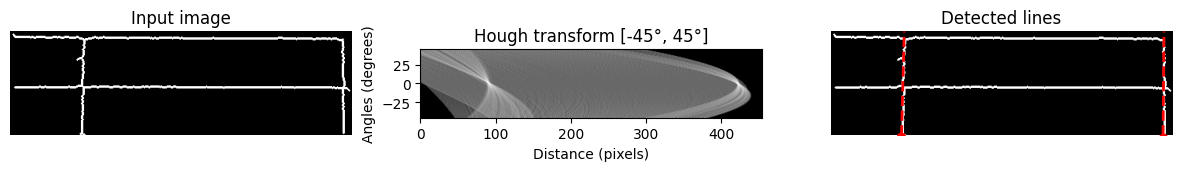

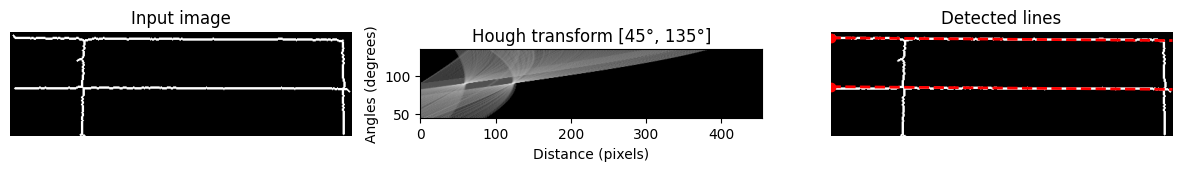

-------!!!!!!!!!../Scaled/scen14.pcd!!!!!!!!!-------
x_dim:[419.1355511546135],y_dim:[30.47584012383595],z_dim:[135.1976253092289]
Looking for poles
(83.99672925849988, -0.7412650499442772)
(411.98395779168993, 3.6357285782981212)
Looking for Boards
(1.015453640308443, 127.99597202218663)
len: 137
[[[0, 82], [135, 84]]]
found a pole from [0, 82] -> [135, 84], with len:135.0148140020198
(x_min,y_min) : (82,0) -> (x_max,y_max) : (84,135)
len: 133
[[[2, 410], [134, 411]]]
found a pole from [2, 410] -> [134, 411], with len:132.00378782444085
(x_min,y_min) : (410,2) -> (x_max,y_max) : (411,135)
Looking for Boards
len: 420
[[[124, 0], [127, 418]]]
found a board from [124, 0] -> [127, 418], with len:418.01076541160995
(x_min,y_min) : (0,124) -> (x_max,y_max) : (419,127)


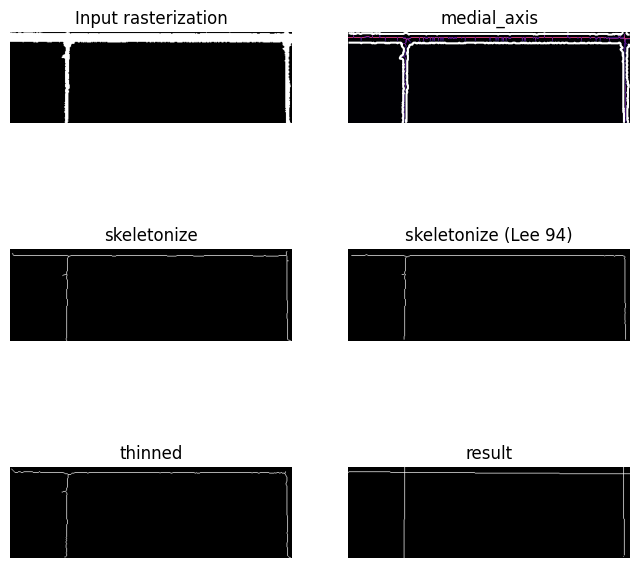

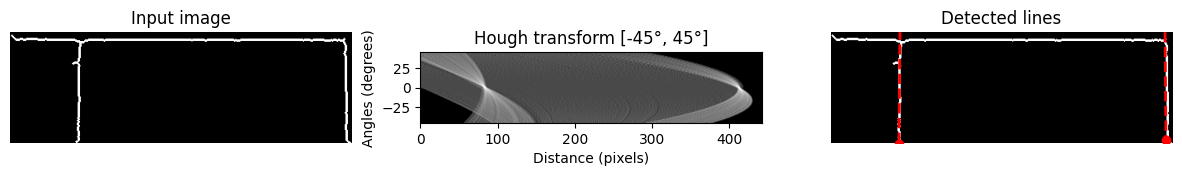

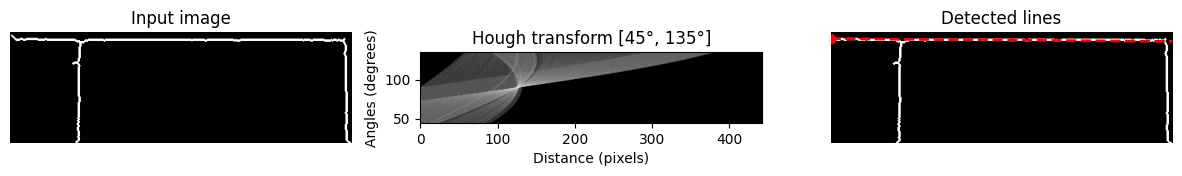

-------!!!!!!!!!../Scaled/scen15.pcd!!!!!!!!!-------
x_dim:[398.94407093524933],y_dim:[35.796878940891474],z_dim:[136.57232760451734]
Looking for poles
(388.98485335186257, 3.432763147956236)
(63.9975080064761, -0.5647733713861159)
Looking for Boards
(8.310334386011368, 69.50495192713018)
(-0.047599389389458874, 5.999811188539999)
(-0.9916539456137266, 124.99606642791663)
len: 135
[[[2, 387], [135, 388]]]
found a pole from [2, 387] -> [135, 388], with len:133.00375934536586
(x_min,y_min) : (387,2) -> (x_max,y_max) : (388,136)
len: 138
[[[0, 62], [136, 64]]]
found a pole from [0, 62] -> [136, 64], with len:136.01470508735443
(x_min,y_min) : (62,0) -> (x_max,y_max) : (64,136)
Looking for Boards
len: 392
[[[22, 7], [68, 397]]]
found a board from [22, 7] -> [68, 397], with len:392.7034504559388
(x_min,y_min) : (7,22) -> (x_max,y_max) : (398,68)
len: 400
[[[4, 0], [8, 398]]]
found a board from [4, 0] -> [8, 398], with len:398.02009999496255
(x_min,y_min) : (0,4) -> (x_max,y_max) : (398,8)
l

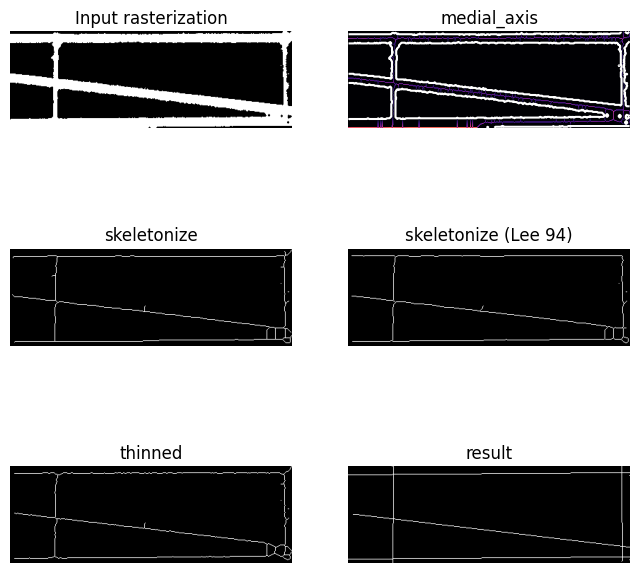

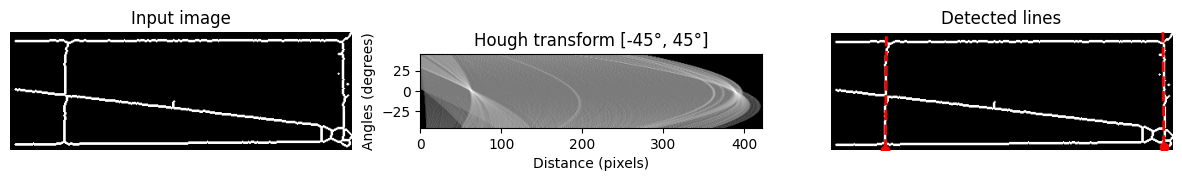

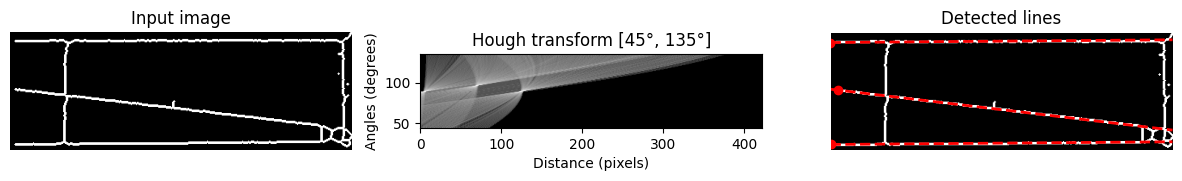

-------!!!!!!!!!../Scaled/scen16.pcd!!!!!!!!!-------
x_dim:[413.92630711197853],y_dim:[23.900827145553194],z_dim:[134.24997851252556]
Looking for poles
(401.984347165678, 3.5474827390190407)
(341.6671370886798, -15.085338366284827)
(66.97652196746253, -1.7735572000948767)
Looking for Boards
(0.49979358858931183, 62.99801747966998)
(0.0634658525192777, 7.999748251386665)
(1.0075204087435334, 126.9960034907633)
len: 132
[[[2, 400], [133, 401]]]
found a pole from [2, 400] -> [133, 401], with len:131.00381673829202
(x_min,y_min) : (400,2) -> (x_max,y_max) : (401,134)
len: 136
[[[0, 340], [134, 347]]]
found a pole from [0, 340] -> [134, 347], with len:134.18271125595876
(x_min,y_min) : (340,0) -> (x_max,y_max) : (347,134)
len: 136
[[[0, 65], [134, 70]]]
found a pole from [0, 65] -> [134, 70], with len:134.09325113517085
(x_min,y_min) : (65,0) -> (x_max,y_max) : (70,134)
Looking for Boards
len: 415
[[[59, 0], [62, 413]]]
found a board from [59, 0] -> [62, 413], with len:413.01089574005186
(x

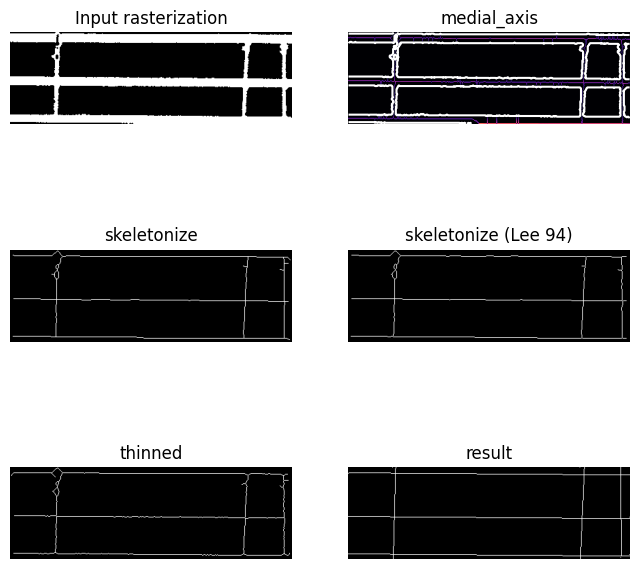

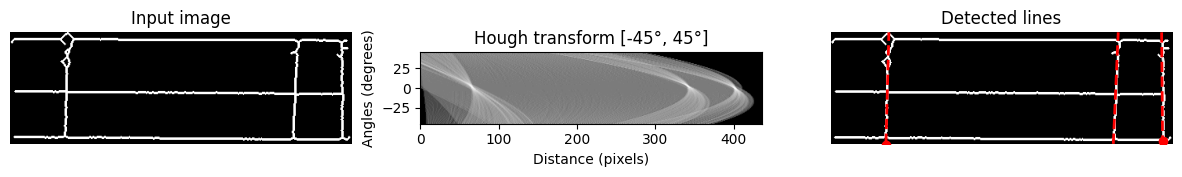

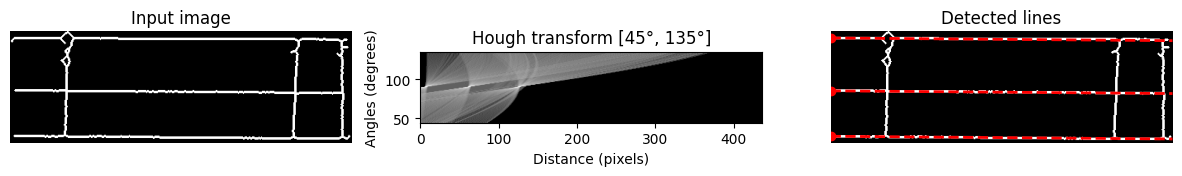

-------!!!!!!!!!../Scaled/scen17.pcd!!!!!!!!!-------
x_dim:[386.3452538847923],y_dim:[48.07459373259917],z_dim:[137.44935998693109]
Looking for poles
(79.97196652831347, -2.117680238919256)
(235.7703051255217, -10.409765656266721)
Looking for Boards
(0.5315265148489506, 66.99789160536332)
(-1.007520408743546, 126.9960034907633)
(0.08726554721400683, 10.999653845656663)
len: 139
[[[0, 78], [137, 83]]]
found a pole from [0, 78] -> [137, 83], with len:137.09121051329294
(x_min,y_min) : (78,0) -> (x_max,y_max) : (83,137)
len: 139
[[[0, 234], [137, 241]]]
found a pole from [0, 234] -> [137, 241], with len:137.17871555019022
(x_min,y_min) : (234,0) -> (x_max,y_max) : (241,137)
Looking for Boards
len: 387
[[[63, 1], [66, 386]]]
found a board from [63, 1] -> [66, 386], with len:385.0116881342695
(x_min,y_min) : (1,63) -> (x_max,y_max) : (386,66)
len: 388
[[[125, 0], [129, 386]]]
found a board from [125, 0] -> [129, 386], with len:386.0207248322297
(x_min,y_min) : (0,125) -> (x_max,y_max) : (38

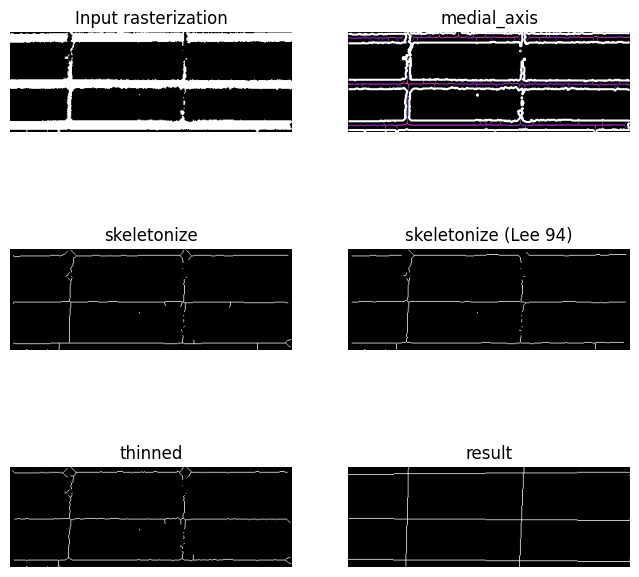

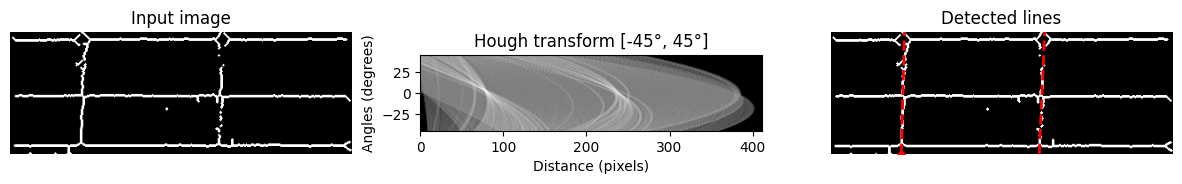

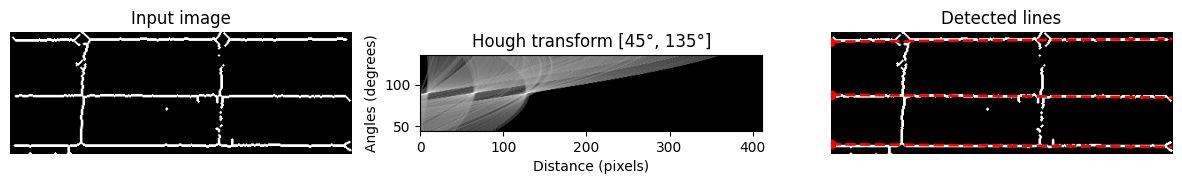

-------!!!!!!!!!../Scaled/scen18.pcd!!!!!!!!!-------
x_dim:[271.50610089302063],y_dim:[26.854893821291625],z_dim:[137.4630399979651]
Looking for poles
(11.99953275121427, -0.10589500713489675)
(169.99338064220214, -1.5001792677443704)
Looking for Boards
(-1.007520408743546, 126.9960034907633)
(0.05553262095436798, 6.999779719963332)
(0.5077268201542215, 63.99798601109332)
len: 139
[[[0, 10], [137, 12]]]
found a pole from [0, 10] -> [137, 12], with len:137.01459776242822
(x_min,y_min) : (10,0) -> (x_max,y_max) : (12,137)
len: 139
[[[0, 168], [137, 170]]]
found a pole from [0, 168] -> [137, 170], with len:137.01459776242822
(x_min,y_min) : (168,0) -> (x_max,y_max) : (170,137)
Looking for Boards
len: 273
[[[125, 0], [128, 271]]]
found a board from [125, 0] -> [128, 271], with len:271.01660465735307
(x_min,y_min) : (0,125) -> (x_max,y_max) : (271,128)
len: 273
[[[4, 0], [6, 271]]]
found a board from [4, 0] -> [6, 271], with len:271.0073799733136
(x_min,y_min) : (0,4) -> (x_max,y_max) : (27

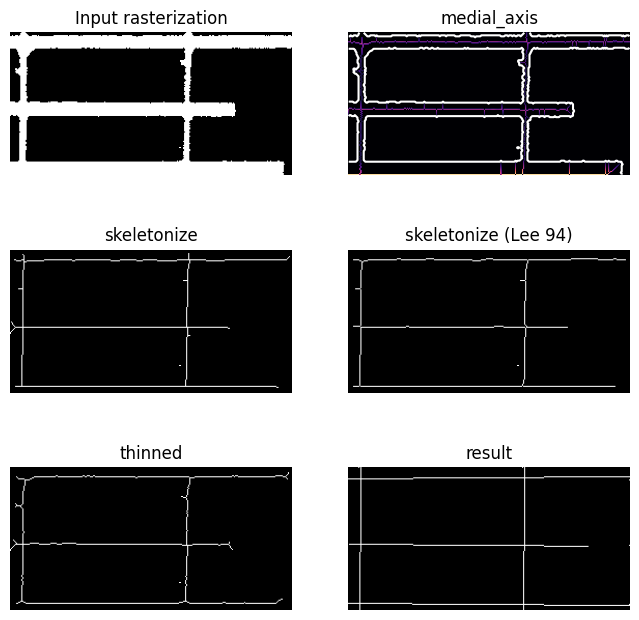

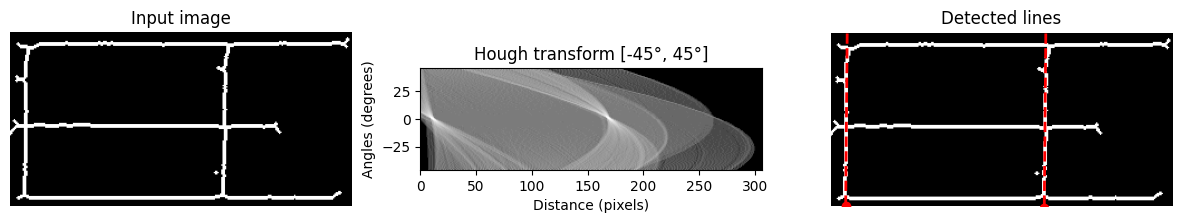

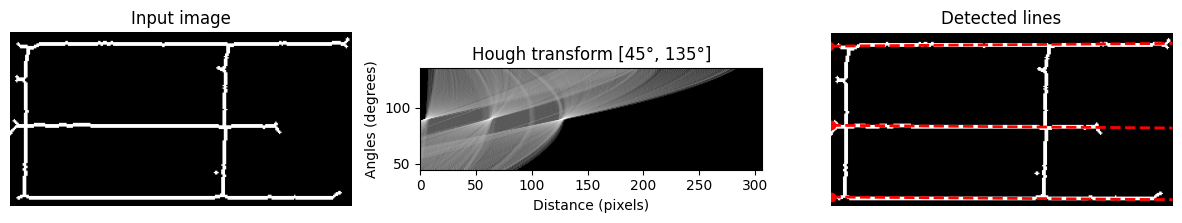

-------!!!!!!!!!../Scaled/scen19.pcd!!!!!!!!!-------
x_dim:[363.14345598220825],y_dim:[74.9172397190705],z_dim:[141.838226467371]
Looking for poles
(348.986410847815, 3.0797797908399134)
(179.99299126821404, -1.5884251070234512)
Looking for Boards
(1.0630530296979013, 133.99578321072664)
(0.08726554721400683, 10.999653845656663)
(0.5473929779787701, 68.99782866820998)
len: 140
[[[2, 347], [140, 348]]]
found a pole from [2, 347] -> [140, 348], with len:138.00362314084367
(x_min,y_min) : (347,2) -> (x_max,y_max) : (348,141)
len: 143
[[[0, 178], [141, 180]]]
found a pole from [0, 178] -> [141, 180], with len:141.01418368376991
(x_min,y_min) : (178,0) -> (x_max,y_max) : (180,141)
Looking for Boards
len: 288
[[[130, 76], [132, 362]]]
found a board from [130, 76] -> [132, 362], with len:286.0069929215018
(x_min,y_min) : (76,130) -> (x_max,y_max) : (363,132)
len: 282
[[[7, 0], [7, 23]], [[7, 107], [10, 363]]]
found a board from [7, 107] -> [10, 363], with len:256.0175775215444
(x_min,y_min) :

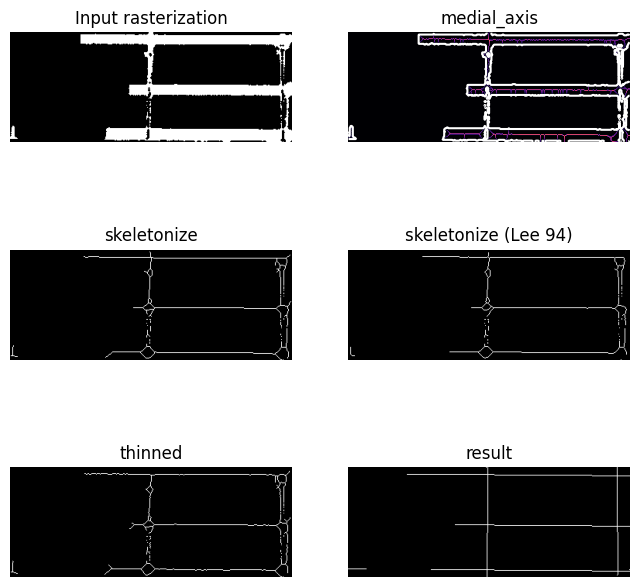

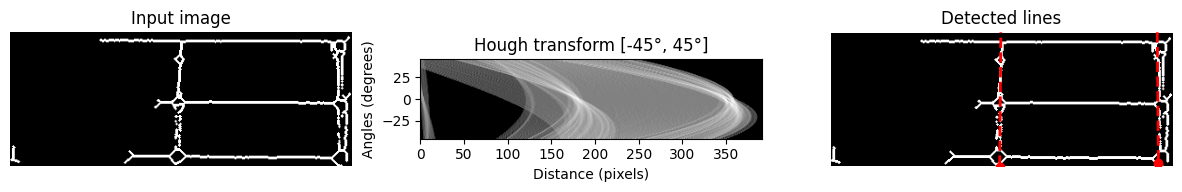

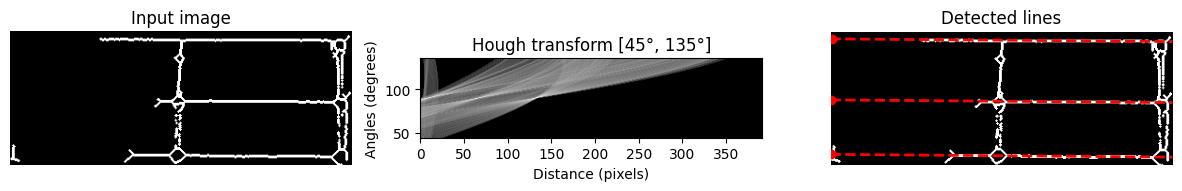

-------!!!!!!!!!../Scaled/scen20.pcd!!!!!!!!!-------
x_dim:[401.29962861537933],y_dim:[22.08415936329402],z_dim:[136.6329599171877]
Looking for poles
(220.922557534466, -5.850091660014445)
(393.9846586648685, 3.4768860675957765)
Looking for Boards
(1.0313201034382624, 129.9959090850333)
(0.5077268201542215, 63.99798601109332)
(-0.03966615782454906, 4.999842657116665)
len: 138
[[[0, 219], [136, 224]]]
found a pole from [0, 219] -> [136, 224], with len:136.09188072769072
(x_min,y_min) : (219,0) -> (x_max,y_max) : (224,136)
len: 135
[[[2, 392], [135, 393]]]
found a pole from [2, 392] -> [135, 393], with len:133.00375934536586
(x_min,y_min) : (392,2) -> (x_max,y_max) : (393,136)
Looking for Boards
len: 402
[[[126, 0], [129, 400]]]
found a board from [126, 0] -> [129, 400], with len:400.0112498418013
(x_min,y_min) : (0,126) -> (x_max,y_max) : (401,129)
len: 402
[[[60, 1], [63, 401]]]
found a board from [60, 1] -> [63, 401], with len:400.0112498418013
(x_min,y_min) : (1,60) -> (x_max,y_max) 

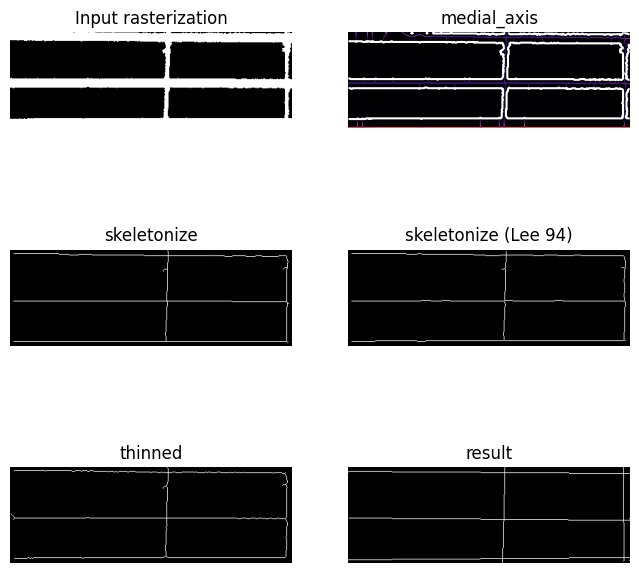

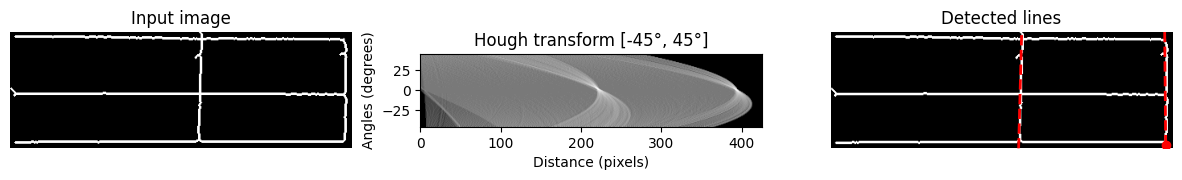

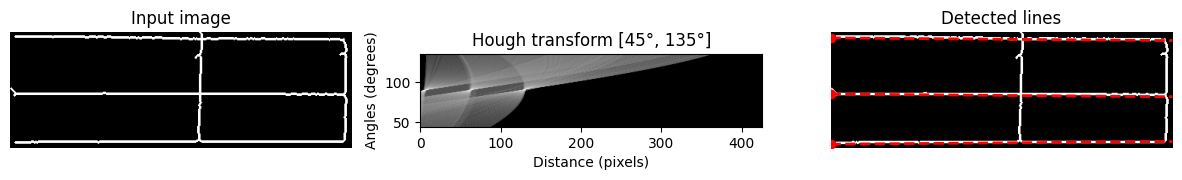

-------!!!!!!!!!../Scaled/scen21.pcd!!!!!!!!!-------
x_dim:[353.35148572921753],y_dim:[9.34875092934817],z_dim:[19.816440157592297]
Looking for poles
(118.62487722579357, 9.441318931452338)
(227.98791707747964, -30.35637769353037)
(350.9863329730174, 3.0974289586957298)
Looking for Boards
(0.3093700680993974, 12.996318331010679)
(115.25840533340724, -115.25840533340725)
(52.32590180780451, -52.32590180780452)
len: 12
[[[8, 117], [18, 117]]]
(x_min,y_min) : (117,8) -> (x_max,y_max) : (118,19)
len: 21
[[[0, 226], [19, 229]]]
(x_min,y_min) : (226,0) -> (x_max,y_max) : (230,19)
len: 18
[[[2, 349], [18, 350]]]
(x_min,y_min) : (349,2) -> (x_max,y_max) : (350,19)
Looking for Boards
len: 107
[[[4, 0], [4, 18]], [[4, 102], [7, 134]], [[7, 217], [10, 250]], [[10, 334], [12, 353]]]
(x_min,y_min) : (0,4) -> (x_max,y_max) : (353,12)
len: 29
[[[0, 114], [19, 133]]]
(x_min,y_min) : (114,0) -> (x_max,y_max) : (134,19)
No railing found


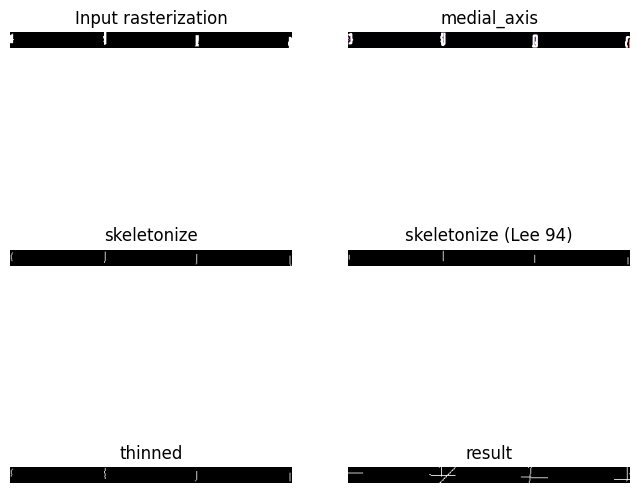

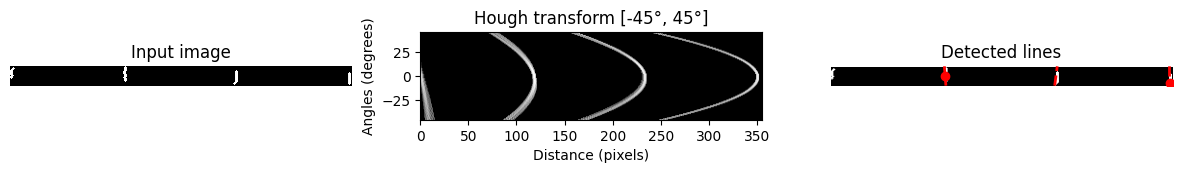

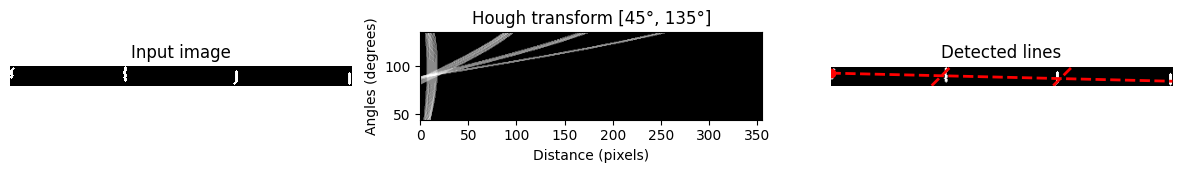

-------!!!!!!!!!../Scaled/scen22.pcd!!!!!!!!!-------
x_dim:[183.04157257080078],y_dim:[30.711650848388672],z_dim:[140.30108451843262]
Looking for poles
(168.99341957960095, 1.4913546838164624)
(10.996145397643103, -0.2911810328513977)
Looking for Boards
(-0.5156600517191378, 64.99795454251665)
(1.0233868718733528, 128.99594055360996)
(-0.0634658525192785, 7.999748251386665)
len: 141
[[[0, 167], [139, 168]]]
found a pole from [0, 167] -> [139, 168], with len:139.00359707575916
(x_min,y_min) : (167,0) -> (x_max,y_max) : (168,140)
len: 142
[[[0, 9], [140, 14]]]
found a pole from [0, 9] -> [140, 14], with len:140.089257261219
(x_min,y_min) : (9,0) -> (x_max,y_max) : (14,140)
Looking for Boards
len: 185
[[[63, 0], [65, 183]]]
found a board from [63, 0] -> [65, 183], with len:183.0109286354233
(x_min,y_min) : (0,63) -> (x_max,y_max) : (183,65)
len: 184
[[[127, 0], [128, 182]]]
found a board from [127, 0] -> [128, 182], with len:182.00274723201295
(x_min,y_min) : (0,127) -> (x_max,y_max) : (1

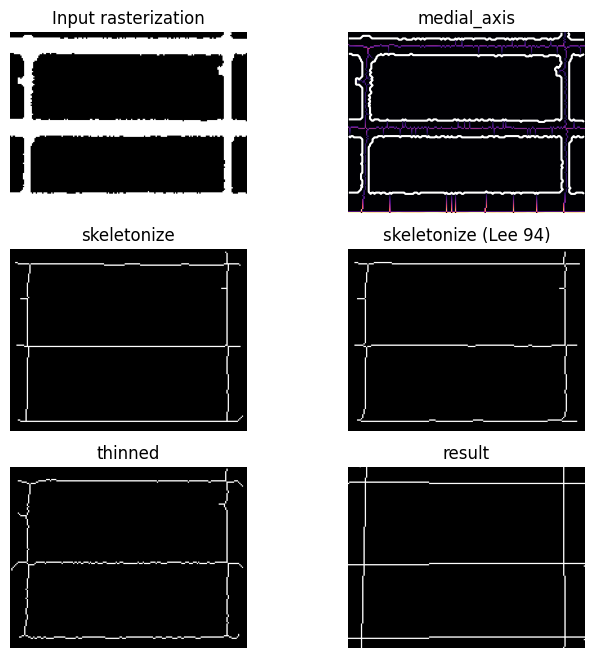

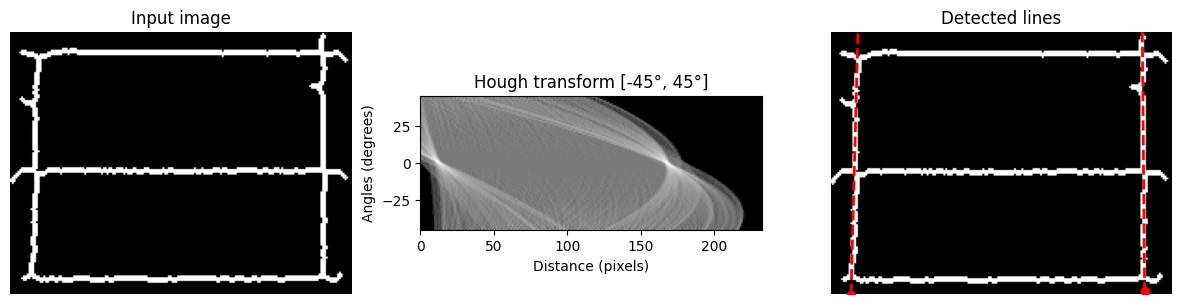

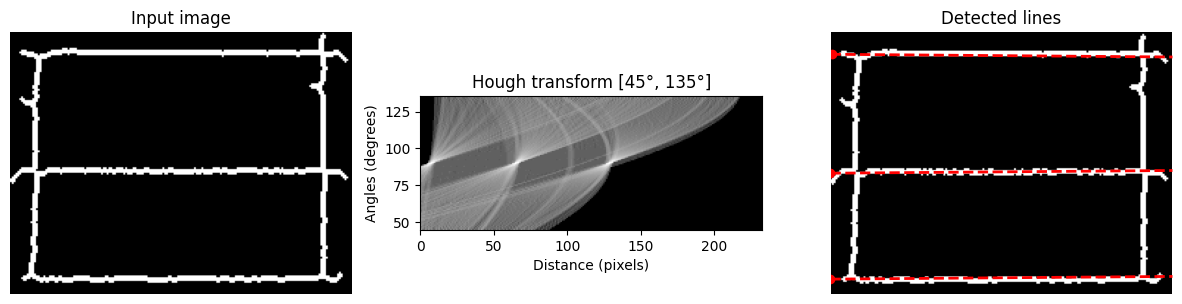

In [7]:
from skimage.morphology import medial_axis, skeletonize, binary_closing, thin, binary_dilation

dictionary_res = {}
from glob import glob
from natsort import natsorted
for file in natsorted(glob("../Scaled/*.pcd")):
    file_dict = {
                "poles":{},
                "boards":{}
            }
    print(f"-------!!!!!!!!!{file}!!!!!!!!!-------")
    im = do_raster(file)
    # im = np.flipud(im)
    # im = binary_closing(im, iterations=5, structure=np.ones((2,2)))
    im = binary_closing(im)
    # im = binary_closing(im)
    # im = binary_closing(im)
    # im = binary_closing(im)
    # im = binary_closing(im)

    thinned= thin(im)

    # Compute the medial axis (skeleton) and the distance transform
    skel, distance = medial_axis(im, return_distance=True)

    # Compare with other skeletonization algorithms
    skeleton = skeletonize(im)
    skeleton_lee = skeletonize(im, method='lee')

    # Distance to the background for pixels of the skeleton
    dist_on_skel = distance * skel


    fig, axes = plt.subplots(3, 2, figsize=(8, 8), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(im, cmap=plt.cm.gray, origin='lower')
    ax[0].set_title('Input rasterization')
    ax[0].axis('off')

    ax[1].imshow(dist_on_skel, cmap='magma',origin='lower')
    ax[1].contour(im, [0.5], colors='w')
    ax[1].set_title('medial_axis')
    ax[1].axis('off')

    ax[2].imshow(skeleton, cmap=plt.cm.gray,origin='lower')
    ax[2].set_title('skeletonize')
    ax[2].axis('off')

    ax[3].imshow(skeleton_lee, cmap=plt.cm.gray,origin='lower')
    ax[3].set_title("skeletonize (Lee 94)")
    ax[3].axis('off')

    ax[4].imshow(thinned, cmap=plt.cm.gray,origin='lower')
    ax[4].set_title("thinned")
    ax[4].axis('off')
    print("Looking for poles")
    poles=perform_hough(binary_dilation(thinned),im, -45,45,90,3,15)
    print("Looking for Boards")
    boards = perform_hough(binary_dilation(thinned), im, 45,135,100, 3, 15)
   




    res = np.zeros(shape=im.shape)
 

    for idx_hough,pole in enumerate(poles):
        file_dict['poles'][f"{idx_hough}"] ={}
        temp = search_along_line(pole[0],pole[1],pole[2],im.astype(np.uint8))
        indexes = np.sort(np.where(temp>0))
        sets =[]
        try:
            start = [indexes[0][0], indexes[1][0]]

            print(f"len: {len(indexes[0])}")
            for idx in range(0,len(indexes[0])-1):
                if np.sqrt((indexes[0][idx+1]-indexes[0][idx] )**2 + (indexes[1][idx+1]-indexes[1][idx])**2) >5:
                    end= [indexes[0][idx], indexes[1][idx]]
                    sets.append([start, end])
                    start = [indexes[0][idx+1], indexes[1][idx+1]]
            end= [indexes[0][idx], indexes[1][idx]]
            sets.append([start, end])
            print(sets)
            for set_id,set in enumerate(sets):
                if float(np.linalg.norm((np.array([set[1]])-np.array([set[0]]))))> 50.0:
                    pole_dict = {"start":{"x":int(set[0][1]),"y":int(set[0][0])}, "end": {"x":int(set[1][1]),"y":int(set[1][0])}, "length":float(np.linalg.norm((np.array([set[1]])-np.array([set[0]]))))}
                    file_dict['poles'][f"{idx_hough}"][f"{set_id}"] = pole_dict
                    print(f"found a pole from {set[0]} -> {set[1]}, with len:{np.linalg.norm((np.array([set[1]])-np.array([set[0]])))}")

            # mean = np.mean(temp)
            x_min = np.min(indexes[1])
            x_max = np.max(indexes[1])
            y_min = np.min(indexes[0])
            y_max = np.max(indexes[0])
        except ValueError:
            print("No railing found")
            continue
        except IndexError as IE:
            print("No railing found")
            continue
        print(f"(x_min,y_min) : ({x_min},{y_min}) -> (x_max,y_max) : ({x_max},{y_max})")
        res = np.logical_or(temp>0, res)


        # break
    print("Looking for Boards")
    # boards = perform_hough(im, 60,120,int(60/1), 3,15)
    
    for idx_hough, board in enumerate(boards):
        file_dict['boards'][f"{idx_hough}"] ={}
        temp = search_along_line(board[0]+np.pi,board[1],board[2],im.astype(np.uint8))
        indexes = np.sort(np.where(temp>0))
        sets =[]
        try: 
            start = [indexes[0][0], indexes[1][0]]
            print(f"len: {len(indexes[0])}")
            for idx in range(0,len(indexes[0])-1):
                if np.sqrt((indexes[0][idx+1]-indexes[0][idx] )**2 + (indexes[1][idx+1]-indexes[1][idx])**2) >5:
                    end= [indexes[0][idx], indexes[1][idx]]
                    sets.append([start, end])
                    start = [indexes[0][idx+1], indexes[1][idx+1]]
            end= [indexes[0][idx], indexes[1][idx]]
            sets.append([start, end])
            print(sets)
            for set_id,set in enumerate(sets):
                if float(np.linalg.norm((np.array([set[1]])-np.array([set[0]])))) > 60.0: # temp solution
                    board_dict = {"start":{"x":int(set[0][1]),"y":int(set[0][0])}, "end": {"x":int(set[1][1]),"y":int(set[1][0])}, "length":float(np.linalg.norm((np.array([set[1]])-np.array([set[0]]))))}
                    file_dict['boards'][f"{idx_hough}"][f"{set_id}"] = board_dict
                    print(f"found a board from {set[0]} -> {set[1]}, with len:{np.linalg.norm((np.array([set[1]])-np.array([set[0]])))}")
            # indexes = np.where(temp>np.mean(temp[np.where(temp>0)]))
        
            x_min = np.min(indexes[1])
            x_max = np.max(indexes[1])
            y_min = np.min(indexes[0])
            y_max = np.max(indexes[0])
        except ValueError:
            print("No railing found")
            continue
        except IndexError as IE:
            print("No railing found")
            continue
        print(f"(x_min,y_min) : ({x_min},{y_min}) -> (x_max,y_max) : ({x_max},{y_max})")
        res = np.logical_or(temp>0, res)
    ax[5].imshow(res, cmap=plt.cm.gray,origin='lower')
    ax[5].set_title("result")
    ax[5].axis('off')
    # plt.colorbar()
    # fig.tight_layout()
    plt.show()
    # plt.show()
    dictionary_res[file] = file_dict




import json
with open("result_2.json", 'w+') as f:
    f.write(json.dumps(dictionary_res, indent=4))

In [15]:
instance = 0
with open("result_2.json") as f:
    dict = json.load(f)
string= ""
string += "% object(FILE_ID, Instance_id, Type, seg(START_X, START_Y, END_X, END_Y)).\n"
# string += "% board(FILE_ID, instance, seg(START_X, START_Y, END_X, END_Y)).\n"
string += "% file_record(FILE, FILE_ID).\n"
string += "% CONSTANTS\n"
string += "parallel_margin(0.005).\n"
string += "length_margin(20).\n"
string += "% FILE RECORDDS\n"
for id,[file, obj] in enumerate(dict.items()):
    string += f"file_record(\"{file}\", {id}).\n"
with open("../bim_props.json") as f:
    bim_properties_dict = json.load(f)

string += "% BIM_PROPERTIES\n"

for id,[file, obj] in enumerate(dict.items()):
    file=file.split('/')[-1]
    string += f"railing_length({id}, {bim_properties_dict[file]['railing_length']}).\n"
for id,[file, obj] in enumerate(dict.items()):
    file=file.split('/')[-1]
    string += f"railing_height({id}, {bim_properties_dict[file]['railing_height']}).\n"
for id,[file, obj] in enumerate(dict.items()):
    file=file.split('/')[-1]
    string += f"min_num_poles({id}, {bim_properties_dict[file]['num_poles']}).\n"
for id,[file, obj] in enumerate(dict.items()):
    file=file.split('/')[-1]
    string += f"min_num_boards({id}, {bim_properties_dict[file]['num_boards']}).\n"

for id,[file, obj] in enumerate(dict.items()):
    # print(obj)
    for hough in obj['poles'].values():
        for pole in hough.values():
            # print(pole['start']['x'])
            string += f"object({id}, {instance}, pole, seg({pole['start']['x']}, {pole['start']['y']}, {pole['end']['x']}, {pole['end']['y']})).\n"
            instance +=1
for id, [file, obj] in enumerate(dict.items()):  
    for hough in obj['boards'].values():
        for board in hough.values():
            string += f"object({id}, {instance}, board, seg({board['start']['x']}, {board['start']['y']}, {board['end']['x']}, {board['end']['y']})).\n"
            instance +=1
with open("../Prolog/knowledge.pl", 'w+') as f:
    
    f.write(string)






In [14]:
instance = 0
with open("result_2.json") as f:
    dict = json.load(f)
string= ""
string += "% object(FILE_ID, Instance_id, Type, seg(START_X, START_Y, END_X, END_Y)).\n"
# string += "% board(FILE_ID, instance, seg(START_X, START_Y, END_X, END_Y)).\n"
string += "% file_record(FILE, FILE_ID).\n"
string += "% CONSTANTS\n"
string += "parallel_margin(0.005).\n"
string += "length_margin(20).\n"
string += "% FILE RECORDDS\n"
with open("../bim_props.json") as f:
    bim_properties_dict = json.load(f)
for id,[file, obj] in enumerate(dict.items()):
    string += f"file_record(\"{file}\", {id}).\n"
    file=file.split('/')[-1]
    string += f"railing_length({id}, {bim_properties_dict[file]['railing_length']}).\n"

    string += f"railing_height({id}, {bim_properties_dict[file]['railing_height']}).\n"

    string += f"min_num_poles({id}, {bim_properties_dict[file]['num_poles']}).\n"

    string += f"min_num_boards({id}, {bim_properties_dict[file]['num_boards']}).\n"
    for hough in obj['poles'].values():
        for pole in hough.values():
            # print(pole['start']['x'])
            string += f"object({id}, {instance}, pole, seg({pole['start']['x']}, {pole['start']['y']}, {pole['end']['x']}, {pole['end']['y']})).\n"
            instance +=1
    for hough in obj['boards'].values():
        for board in hough.values():
            string += f"object({id}, {instance}, board, seg({board['start']['x']}, {board['start']['y']}, {board['end']['x']}, {board['end']['y']})).\n"
            instance +=1
with open("../Prolog/knowledge_Sort_on_file.pl", 'w+') as f:
    f.write(string)


In [ ]:
import numpy as np
  
  
arr = [[1, 3], [9, 5]]
  
# padding array using 'maximum' mode
pad_arr = np.pad(arr, [(3,),(2,)], 'constant', constant_values=(0, 0))
  
print(pad_arr)

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 3 0 0]
 [0 0 9 5 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [ ]:
import json
violations = []
with open("gt.json") as f:
    dict = json.load(f)
    for key, value in dict.items():
        violations.extend(value['violations'])

violations = set(violations)



for idx,vio in enumerate(violations):
    print(f"violation(violation_id, {idx}, {vio}).")


violation(violation_id, 0, middle_pole_missing).
violation(violation_id, 1, left_pole_missing).
violation(violation_id, 2, toe_board_too_short).
violation(violation_id, 3, top_board_sloped).
violation(violation_id, 4, middle_board_too_high).
violation(violation_id, 5, middle_board_sloped).
violation(violation_id, 6, middle_pole_too_far_right).
violation(violation_id, 7, right_pole_missing).
violation(violation_id, 8, middle_board_too_short).
violation(violation_id, 9, middle_board_missing).
violation(violation_id, 10, toe_board_missing).
violation(violation_id, 11, top_board_missing).
violation(violation_id, 12, top_board_too_short).
violation(violation_id, 13, middle_board_too_low).


In [ ]:
import json
string = "% class(class_id, ID, Name). \n"
string +="% class(violation, ID, Violation). \n"
class_names=[]
with open("gt.json") as f:
    dict = json.load(f)
    for key, value in dict.items():
        string +=f"class(class_id, {key}, \"{value['name']}\"). \n"
        class_names.append(value['name'])
        for violation in value['violations']:
            string +=f"class(violation, {key}, {violation}). \n"
        # violations.extend(value['violations'])

with open("../Prolog/classes.pl",'w+') as f:
    f.write(string)

In [5]:
import json
instance = 0
with open("result_2.json") as f:
    dict = json.load(f)
string= ""
string += "% object(FILE_ID, Instance_id, Type, seg(START_X, START_Y, END_X, END_Y)).\n"
# string += "% board(FILE_ID, instance, seg(START_X, START_Y, END_X, END_Y)).\n"
string += "% file_record(FILE, FILE_ID).\n"
string += "% CONSTANTS\n"
string += "parallel_margin(0.005).\n"
string += "length_margin(20).\n"
string += "% FILE RECORDDS\n"

REPLICAS = 100
with open("../bim_props.json") as f:
        bim_properties_dict = json.load(f)
for i in range(0,REPLICAS):
    off= i*21+i  
    for id, [file, obj] in enumerate(dict.items()):
        string += f"file_record(\"{file}\", {off+id}).\n"
    string += "% BIM_PROPERTIES\n"
for i in range(0,REPLICAS):
    off= i*21+i  
    for id,[file, obj] in enumerate(dict.items()):
        file=file.split('/')[-1]
        string += f"railing_length({off+id}, {bim_properties_dict[file]['railing_length']}).\n"
for i in range(0,REPLICAS):
    off= i*21+i   
    for id,[file, obj] in enumerate(dict.items()):
        file=file.split('/')[-1]
        string += f"railing_height({off+id}, {bim_properties_dict[file]['railing_height']}).\n"
for i in range(0,REPLICAS):
    off= i*21    
    for id,[file, obj] in enumerate(dict.items()):
        file=file.split('/')[-1]
        string += f"min_num_poles({off+id}, {bim_properties_dict[file]['num_poles']}).\n"
for i in range(0,REPLICAS):
    off= i*21+i    
    for id,[file, obj] in enumerate(dict.items()):
        file=file.split('/')[-1]
        string += f"min_num_boards({off+id}, {bim_properties_dict[file]['num_boards']}).\n"
for i in range(0,REPLICAS):
    off= i*21+i   
    for id,[file, obj] in enumerate(dict.items()):
        # print(obj)
        for hough in obj['poles'].values():
            for pole in hough.values():
                # print(pole['start']['x'])
                string += f"object({off+id}, {instance}, pole, seg({pole['start']['x']}, {pole['start']['y']}, {pole['end']['x']}, {pole['end']['y']})).\n"
                instance +=1
for i in range(0,REPLICAS):
    off= i*21+i    
    for id, [file, obj] in enumerate(dict.items()):  
        for hough in obj['boards'].values():
            for board in hough.values():
                string += f"object({off+id}, {instance}, board, seg({board['start']['x']}, {board['start']['y']}, {board['end']['x']}, {board['end']['y']})).\n"
                instance +=1
with open("../Prolog/knowledge_feasability.pl", 'w+') as f:
    
    f.write(string)






In [1]:
import json
instance = 0
with open("result_2.json") as f:
    dict = json.load(f)
string= ""
string += "% object(FILE_ID, Instance_id, Type, seg(START_X, START_Y, END_X, END_Y)).\n"
# string += "% board(FILE_ID, instance, seg(START_X, START_Y, END_X, END_Y)).\n"
string += "% file_record(FILE, FILE_ID).\n"
string += "% CONSTANTS\n"
string += "parallel_margin(0.005).\n"
string += "length_margin(20).\n"
string += "% FILE RECORDDS\n"
REPLICAS = 10000
Iterations = range(0,REPLICAS+1, 1)
Iterations = [1,10,20,30,40,50,60,70,80,90,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000,10000]
with open("../bim_props.json") as f:
        bim_properties_dict = json.load(f)

for iteration in Iterations:
    off= (iteration)*21+1
    for i in range(1,off):
        string += f"file_iteration_mapping({iteration}, {i}).\n"

# REPLICAS = 2
for i in range(0,REPLICAS):
    off= i*21+i  
    for id, [file, obj] in enumerate(dict.items()):
        string += f"file_record(\"{file}\", {off+id}).\n"
    string += "% BIM_PROPERTIES\n"

for i in range(0,REPLICAS):
    off= i*21+i  
    for id,[file, obj] in enumerate(dict.items()):
        file=file.split('/')[-1]
        string += f"railing_length({off+id}, {bim_properties_dict[file]['railing_length']}).\n"


for i in range(0,REPLICAS):
    off= i*21+i   
    for id,[file, obj] in enumerate(dict.items()):
        file=file.split('/')[-1]
        string += f"railing_height({off+id}, {bim_properties_dict[file]['railing_height']}).\n"


for i in range(0,REPLICAS):
    off= i*21    
    for id,[file, obj] in enumerate(dict.items()):
        file=file.split('/')[-1]
        string += f"min_num_poles({off+id}, {bim_properties_dict[file]['num_poles']}).\n"


for i in range(0,REPLICAS):
    off= i*21+i    
    for id,[file, obj] in enumerate(dict.items()):
        file=file.split('/')[-1]
        string += f"min_num_boards({off+id}, {bim_properties_dict[file]['num_boards']}).\n"

for i in range(0,REPLICAS):
    off= i*21+i   
    for id,[file, obj] in enumerate(dict.items()):
        # print(obj)
        for hough in obj['poles'].values():
            for pole in hough.values():
                # print(pole['start']['x'])
                string += f"object({off+id}, {instance}, pole, seg({pole['start']['x']}, {pole['start']['y']}, {pole['end']['x']}, {pole['end']['y']})).\n"
                instance +=1


for i in range(0,REPLICAS):
    off= i*21+i    
    for id, [file, obj] in enumerate(dict.items()):  
        for hough in obj['boards'].values():
            for board in hough.values():
                string += f"object({off+id}, {instance}, board, seg({board['start']['x']}, {board['start']['y']}, {board['end']['x']}, {board['end']['y']})).\n"
                instance +=1
with open("../Prolog/knowledge_feasability_2.pl", 'w+') as f:
    
    f.write(string)


In [23]:
import ast
def convert(in_str):
    in_str = in_str.replace('[','')
    in_str = in_str.replace(']','')
    in_str = in_str.replace('time','')
    in_str = in_str.replace('(','')
    in_lst= in_str.split('),')
    dict={}
    for iteration in in_lst:
        it_list = iteration.split(',')
        dict[int(it_list[0])]={
            'number_of_files':int(it_list[1]),
            'cpu_time':float(it_list[2].replace('{cpu:','')),
            'inference':float(it_list[3].replace('inferences:','')),
            'wall':float(it_list[4].replace('wall:','').replace('}','').replace(')',''))
        }
    return dict

# with open("../Prolog/output_100_1.txt",'r') as f:
#     fes_txt= f.read()
# with open("../Prolog/output_200_10.txt",'r') as f:
#     fes_txt+= f.read()
# with open("../Prolog/output_1000_100.txt",'r') as f:
#     fes_txt+= f.read()
# output_1000_1-10-100

with open("../Prolog/output_10000_10_50_v1.txt",'r') as f:
    fes_txt= f.read()
dictionary = convert(fes_txt)



Text(0, 0.5, 'Processing time (seconds)')

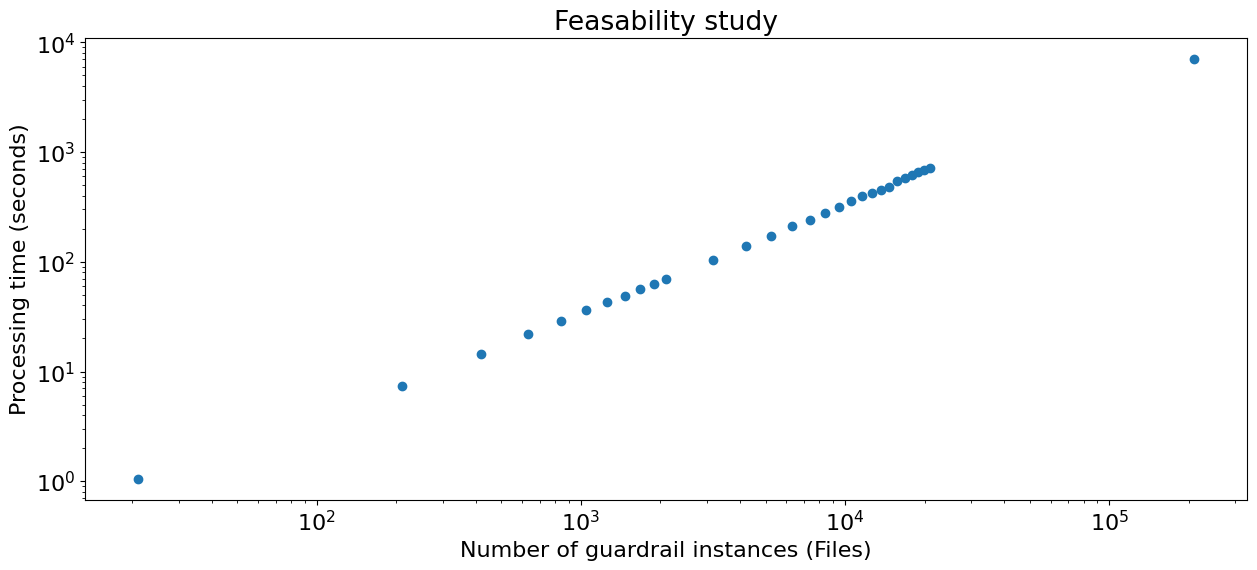

In [24]:
import matplotlib.pyplot as plt
import numpy as np
its = []
times = []
number_of_files = []
for key,val in dictionary.items():
    its.append(key)
    times.append(val['cpu_time'])
    number_of_files.append(val['number_of_files'])

fig, axes = plt.subplots(1,1, figsize=(15, 6))
# axes[0].scatter(its,times)

# axes[0].set_title('Title')
# axes[0].set_xlabel('Iteration')
# axes[0].set_ylabel('Processing time (seconds)')

axes.scatter(number_of_files, times)

axes.set_title('Feasability study')
axes.set_xlabel('Number of guardrail instances (Files)')
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_ylabel('Processing time (seconds)')


for key,val in dic

Text(0, 0.5, 'Processing time [minutes]')

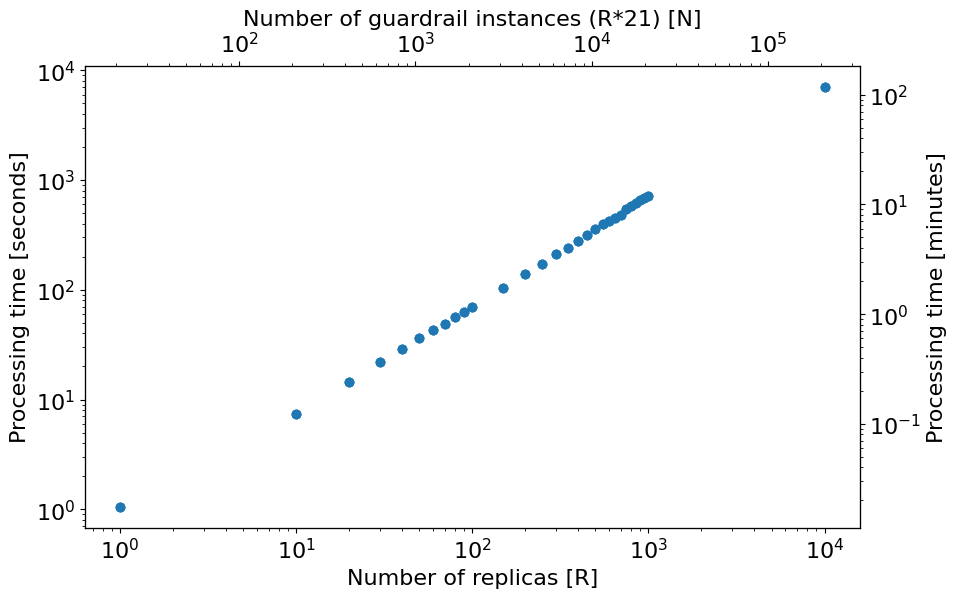

In [30]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1,1, figsize=(10, 6))
# axes[0].scatter(its,times)

# axes[0].set_title('Title')
# axes[0].set_xlabel('Iteration')
# axes[0].set_ylabel('Processing time (seconds)')

axes.scatter(its, times)

# fig.suptitle("Feasible study \n")
axes.set_xlabel('Number of replicas [R]')
axes_2 = axes.twiny()
axes_3 = axes.twinx()
axes_2.scatter(number_of_files, times)
axes_3.scatter(its, list(np.array(times)/60))

axes_2.set_xlabel('Number of guardrail instances (R*21) [N]')
axes.set_xscale('log')
axes.set_yscale('log')
axes_2.set_xscale('log')
axes_2.set_yscale('log')
axes_3.set_xscale('log')
axes_3.set_yscale('log')
axes.set_ylabel('Processing time [seconds]')
axes_3.set_ylabel('Processing time [minutes]')

In [31]:
Iterations = [1,10,20,30,40,50,60,70,80,90,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000,10000]
np.array(Iterations)*21
print(len(Iterations))
for idx,I in enumerate(its):
    print(f"R={I}, N={number_of_files[idx]}, T={round(times[idx],2)} sec")

30
R=1, N=21, T=1.06 sec
R=10, N=210, T=7.3 sec
R=20, N=420, T=14.58 sec
R=30, N=630, T=21.9 sec
R=40, N=840, T=29.15 sec
R=50, N=1050, T=36.51 sec
R=60, N=1260, T=43.14 sec
R=70, N=1470, T=49.3 sec
R=80, N=1680, T=55.95 sec
R=90, N=1890, T=62.41 sec
R=100, N=2100, T=69.13 sec
R=150, N=3150, T=104.35 sec
R=200, N=4200, T=138.19 sec
R=250, N=5250, T=172.93 sec
R=300, N=6300, T=209.92 sec
R=350, N=7350, T=242.04 sec
R=400, N=8400, T=276.43 sec
R=450, N=9450, T=313.74 sec
R=500, N=10500, T=361.01 sec
R=550, N=11550, T=398.79 sec
R=600, N=12600, T=422.51 sec
R=650, N=13650, T=451.59 sec
R=700, N=14700, T=484.87 sec
R=750, N=15750, T=546.21 sec
R=800, N=16800, T=582.95 sec
R=850, N=17850, T=618.84 sec
R=900, N=18900, T=654.42 sec
R=950, N=19950, T=687.05 sec
R=1000, N=21000, T=717.99 sec
R=10000, N=210000, T=7137.79 sec
